<h1><center>Is the MLB All Star Game a Popularity Contest or Are Nominations Founded on Actual Statistics?</center></h1>
<h2><center>Chris Emm</center></h2>

In [3]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import requests
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
import seaborn
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Saving Session Data

In [178]:
import dill
#dill.dump_session('notebook_env.db')

#### Loading Session Data

In [1]:
import dill
dill.load_session('notebook_env.db')

### Introduction

Major League Baseball's All Star game, which is held every July, with the excepion of the COVID-shortened 2020 season, is about highlighting the top players in the game and allowing them to play on the same teams in front of a national audience. In order to determine which players make the game, there are three votes -- fan, player, and coach. Ideally, the players who perform the best should make the All Star game, however it is possible that a avid fanbase can vote for their team's players even if they are performing well. In this project, I am going to analyze whether the All Star game truly has the season's biggest and brightest stars, or whether the game is simply a popularity vote.

Baseball is a game of scoring runs. There's a reason that the team with the most runs at the end of a game wins. Major Leage Baseball (MLB), especially in the past 20 years has seen an uptick of scoring, as the game has become more and more about offensive firepower rather than pitchers completely dominating the hitters. A team's front office and everyone that is included in the decision making process of  roster formations need to be able to analyze player performance and determine which players will score them the most runs, and in effect, help them win the most games. In this project, we will analyze which offensive metrics are most closely related to scoring runs, using team data between 2011-2021. Then, based on our findings, we will analyze whether or not the players who make the All Star game arer also the one's who are producing the most at the plate.

### Part I: Scraping Team Data for 2000-2021 Seasons

The first thing we are going to do is analyze a variety of offensive metrics and their relation to producing runs on offense. In order to do this, we will need to scrape team data from FanGraphs (https://www.fangraphs.com/). We will gather basic, advanced, and batted ball, statcast and plate discipline data that each team accumulated over each season for the last decade. Below are two functions that scrape the data from the website.

The following function scrapes the table that is located at the specified url, and creates a dataframe using pandas from the table that is scraped. The additional year and team arguments allow us to add respective columns based on which team each row is for.

In [3]:
def scraping_FanGraphs(url, year, team):
    # Extracting text from webpage
    html = requests.get(url).text

    # Parsing the text into html code
    soup = BeautifulSoup(html,"html.parser")

    # Finding the table in the html code - we are searching by the id of the table
    table = soup.find("table", attrs={"class": "rgMasterTable"})


    table_data = table.tbody.find_all("tr")

    dataset = []
    for tr in table_data:
        temp = ()
        for td in tr.find_all("td"):
            if '\xa0' in td.text:
                temp += ('0.0',)
            else:
                temp += (td.text,)
        dataset.append(temp)

    stats = pd.DataFrame(data = dataset)
    stats = stats.replace(to_replace=" NULL",value=0)

    table_header = table.thead.find_all("tr")
    columns = []
    count = 0
    for tr in table_header:
        if count == 1:
            th = tr.find_all("th")
            for a in th:
                columns.append(a.text)
        count = 1
    stats.columns = columns
    stats = stats.assign(Year = year)
    if team != 'None':
        stats = stats.assign(Team = team)
    
    return stats

The function below simply compiles a list of urls based on which FanGraphs page we want to visit. Since each statistical category is on a separate url, we have an argument, called stat, which determines which url we are looking to scrape from. This function will be used to create urls for all 30 MLB teams for the years that are specified (2011-2021). The page argument is used because some teams have too many players to fit on one page, so the remaining are placed on separate pages. As you can see, we wil use this function for both team and player scraping.

In [4]:
def get_urls(team, year, page, stat):
    
######################################################################
#                      Player Stats Urls                             #
######################################################################

    if stat == 'player_standard':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat' \
            '&lg=all&qual=0&type=0&season=' + str(year[1]) + '&month=0&season1=' + str(year[0]) + '&ind=1' \
            '&team='+ str(team) +'&rost=0&age=0&filter=&players=0&startdate=&enddate=&page=' + str(page) + '_50'
        
    if stat == 'player_advanced':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat' \
            '&lg=all&qual=0&type=1&season=' + str(year[1]) + '&month=0&season1=' + str(year[0]) + '&ind=1' \
            '&team='+ str(team) +'&rost=0&age=0&filter=&players=0&startdate=&enddate=&page=' + str(page) + '_50'
    
    if stat == 'player_batted':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat' \
            '&lg=all&qual=0&type=2&season=' + str(year[1]) + '&month=0&season1=' + str(year[0]) + '&ind=1' \
            '&team='+ str(team) +'&rost=0&age=0&filter=&players=0&startdate=&enddate=&page=' + str(page) + '_50'
        
    if stat == 'player_statcast':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat' \
            '&lg=all&qual=0&type=24&season=' + str(year[1]) + '&month=0&season1=' + str(year[0]) + '&ind=1' \
            '&team='+ str(team) +'&rost=0&age=0&filter=&players=0&startdate=&enddate=&page=' + str(page) + '_50'
        
    if stat == 'player_plate_discipline':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat' \
            '&lg=all&qual=0&type=5&season=' + str(year[1]) + '&month=0&season1=' + str(year[0]) + '&ind=1' \
            '&team='+ str(team) +'&rost=0&age=0&filter=&players=0&startdate=&enddate=&page=' + str(page) + '_50'
        
######################################################################
#                        Team Stats Urls                             #
######################################################################

    if stat == 'team':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=0&season=' + str(year) +  \
            '&month=0&season1=' + str(year) + '&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31'
    
    if stat == 'team_advanced':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat' \
            '&lg=all&qual=0&type=1&season=' + str(year) + '&month=0&season1=' + str(year) + '&ind=0&team=0,'\
            'ts&rost=0&age=0&filter=&players=0&startdate=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31'
    
    if stat == 'team_batted':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat' \
            '&lg=all&qual=0&type=2&season=' + str(year) + '&month=0&season1=' + str(year) + '&ind=0&'\
            'team=0,ts&rost=0&age=0&filter=&players=0&startdate=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31'

    if stat == 'team_statcast':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat' \
            '&lg=all&qual=0&type=24&season=' + str(year) + '&month=0&season1=' + str(year) + '&ind=0' \
            '&team=0,ts&rost=0&age=0&filter=&players=0&startdate=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31'
     
    if stat == 'team_plate_discipline':
        url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat' \
            '&lg=all&qual=0&type=5&season=' + str(year) + '&month=0&season1=' + str(year) + '&ind=0' \
            '&team=0,ts&rost=0&age=0&filter=&players=0&startdate=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31'
    return url

#### Scraping Team Data From Fangraphs

Below, we are actually compiling the web scrape results and merging all resulting dataframes into one overall dataframe called team_batting. We will perofrm our initial analysis on this dataset.

In [5]:
years = [i for i in range(2000,2022)]

######################################################################
#              Creating a Dataframe for Team Stats                   #
######################################################################

count = 0
for year in years:
    # Since we are scraping for team, we don't need to specify a team or page (those are arguments for player scraping)
    url = get_urls('None', year, 'None', 'team')
    if count == 0:
        team_batting = scraping_FanGraphs(url, year, 'None')
        # In 2011, Miami Marlins were the Florida Marlins (they changed to Miami in 2012)
        team_batting['Team'] = team_batting['Team'].replace({'FLA':'MIA'}, regex = True)
        count = 1
    else:
        team_batting = pd.concat([team_batting, scraping_FanGraphs(url, year, 'None')])
            
    
team_batting = team_batting.drop_duplicates()
team_batting = team_batting.reset_index(drop=True)
team_batting = team_batting[['Year', 'Team', 'AB', 'PA', 'AVG', 'H', '1B', '2B', \
                             '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', \
                             'SF', 'SH', 'GDP', 'SB', 'CS']]

######################################################################
#           Adding Advanced Batting Stats to Dataframe               #
######################################################################

count = 0
for year in years:
    # Since we are scraping for team, we don't need to specify a team or page (those are arguments for player scraping)
    url = get_urls('None', year, 'None', 'team_advanced')
    if count == 0:
        team_advanced_batting = scraping_FanGraphs(url, year, 'None')
        # In 2011, Miami Marlins were the Florida Marlins (they changed to Miami in 2012)
        team_batting['Team'] = team_batting['Team'].replace({'FLA':'MIA'}, regex = True)
        count = 1
    else:
        team_advanced_batting = pd.concat([team_advanced_batting, scraping_FanGraphs(url, year, 'None')])
            
    
team_advanced_batting = team_advanced_batting.drop_duplicates()
team_advanced_batting = team_advanced_batting.reset_index(drop=True)
team_advanced_batting = team_advanced_batting[['Year', 'Team', 'PA', 'BB%', 'K%', \
                                               'BB/K', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', \
                                               'Spd', 'BABIP', 'UBR', 'wGDP', 'wSB', 'wRC', \
                                               'wRAA', 'wOBA', 'wRC+']]

# Merge data into team batting dataframe
team_batting = pd.merge(team_batting, team_advanced_batting, on = ['Year', 'Team', 'PA', 'AVG'])

######################################################################
#             Adding Batted Ball Stats to Dataframe                  #
######################################################################

count = 0
for year in years:
    # Since we are scraping for team, we don't need to specify a team or page (those are arguments for player scraping)
    url = get_urls('None', year, 'None', 'team_batted')
    if count == 0:
        team_advanced_batting = scraping_FanGraphs(url, year, 'None')
        # In 2011, Miami Marlins were the Florida Marlins (they changed to Miami in 2012)
        team_batting['Team'] = team_batting['Team'].replace({'FLA':'MIA'}, regex = True)
        count = 1
    else:
        team_advanced_batting = pd.concat([team_advanced_batting, scraping_FanGraphs(url, year, 'None')])
            
    
team_advanced_batting = team_advanced_batting.drop_duplicates()
team_advanced_batting = team_advanced_batting.reset_index(drop=True)
team_advanced_batting = team_advanced_batting[['Year', 'Team', 'BABIP', 'GB/FB', \
                                               'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', \
                                               'IFH', 'IFH%', 'BUH', 'BUH%', 'Pull%', \
                                               'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%']]

# Merge data into team batting dataframe
team_batting = pd.merge(team_batting, team_advanced_batting, on = ['Year', 'Team', 'BABIP'])

######################################################################
#               Adding Statcast Data to Dataframe                    #
######################################################################

count = 0
for year in years:
    # Since we are scraping for team, we don't need to specify a team or page (those are arguments for player scraping)
    url = get_urls('None', year, 'None', 'team_statcast')
    if count == 0:
        team_advanced_batting = scraping_FanGraphs(url, year, 'None')
        # In 2011, Miami Marlins were the Florida Marlins (they changed to Miami in 2012)
        team_batting['Team'] = team_batting['Team'].replace({'FLA':'MIA'}, regex = True)
        count = 1
    else:
        team_advanced_batting = pd.concat([team_advanced_batting, scraping_FanGraphs(url, year, 'None')])
            
    
team_advanced_batting = team_advanced_batting.drop_duplicates()
team_advanced_batting = team_advanced_batting.reset_index(drop=True)
team_advanced_batting = team_advanced_batting[['Year', 'Team', 'EV', 'LA', 'Barrel%', 'HardHit%']]

# Merge data into team batting dataframe
team_batting = pd.merge(team_batting, team_advanced_batting, on = ['Year', 'Team'])

######################################################################
#           Adding Plate Discipline Data to Dataframe                #
######################################################################

count = 0
for year in years:
    # Since we are scraping for team, we don't need to specify a team or page (those are arguments for player scraping)
    url = get_urls('None', year, 'None', 'team_plate_discipline')
    if count == 0:
        team_advanced_batting = scraping_FanGraphs(url, year, 'None')
        # In 2011, Miami Marlins were the Florida Marlins (they changed to Miami in 2012)
        team_batting['Team'] = team_batting['Team'].replace({'FLA':'MIA'}, regex = True)
        count = 1
    else:
        team_advanced_batting = pd.concat([team_advanced_batting, scraping_FanGraphs(url, year, 'None')])
            
    
team_advanced_batting = team_advanced_batting.drop_duplicates()
team_advanced_batting = team_advanced_batting.reset_index(drop=True)
team_advanced_batting = team_advanced_batting[['Year', 'Team', 'O-Swing%', 'Z-Swing%', 'Swing%', \
                                               'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', \
                                               'F-Strike%', 'SwStr%', 'CStr%', 'CSW%']]

# Merge data into team batting dataframe
team_batting = pd.merge(team_batting, team_advanced_batting, on = ['Year', 'Team'])

######################################################################
#              Adding Wins and Losses to Dataframe                   #
######################################################################

teams_table = pd.read_csv('tables/Teams.csv')
teams_table = teams_table[teams_table.yearID > 1999]

teams_table = teams_table.rename(columns = {'yearID':'Year','franchID':'Team'})

# Taking only the necessary columns
teams_table = teams_table[['Year', 'Team', 'W', 'L']]

data = []
for team_index, team_row in teams_table.iterrows():
    for my_team_index, my_team_row in team_batting.iterrows():
        if my_team_row['Team'] == team_row['Team'] and my_team_row['Year'] == team_row['Year']:
            team = list(my_team_row)
            team.append(team_row['W'])
            team.append(team_row['L'])
            team = tuple(team)
            data.append(team)

# Creating a dataframe from the list of tuples above
team_batting = pd.DataFrame(data, columns=['Year', 'Team', 'AB', 'PA', 'AVG', \
                                           'H', '1B', '2B', '3B', 'HR', 'R', 'RBI',\
                                           'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP',\
                                           'SB', 'CS', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG',\
                                           'OPS', 'ISO', 'Spd', 'BABIP', 'UBR', 'wGDP', \
                                           'wSB', 'wRC', 'wRAA', 'wOBA', 'wRC+', 'GB/FB',\
                                           'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH', \
                                           'IFH%', 'BUH', 'BUH%', 'Pull%', 'Cent%', 'Oppo%',\
                                           'Soft%', 'Med%', 'Hard%', 'EV', 'LA', 'Barrel%', 'HardHit%', \
                                           'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', \
                                           'Contact%', 'Zone%', 'F-Strike%', 'SwStr%', 'CStr%', 'CSW%', 'W', 'L'])

# Removing the % in the values so that they can be used as numbers
team_batting['BB%'] = team_batting['BB%'].replace({'\%':''}, regex = True)
team_batting['K%'] = team_batting['K%'].replace({'\%':''}, regex = True)
team_batting['LD%'] = team_batting['BB%'].replace({'\%':''}, regex = True)
team_batting['GB%'] = team_batting['GB%'].replace({'\%':''}, regex = True)
team_batting['FB%'] = team_batting['FB%'].replace({'\%':''}, regex = True)
team_batting['HR/FB'] = team_batting['HR/FB'].replace({'\%':''}, regex = True)
team_batting['Pull%'] = team_batting['Pull%'].replace({'\%':''}, regex = True)
team_batting['Cent%'] = team_batting['Cent%'].replace({'\%':''}, regex = True)
team_batting['Oppo%'] = team_batting['Oppo%'].replace({'\%':''}, regex = True)
team_batting['Soft%'] = team_batting['Soft%'].replace({'\%':''}, regex = True)
team_batting['Med%'] = team_batting['Med%'].replace({'\%':''}, regex = True)
team_batting['Hard%'] = team_batting['Hard%'].replace({'\%':''}, regex = True)
team_batting['Barrel%'] = team_batting['Barrel%'].replace({'\%':''}, regex = True)
team_batting['HardHit%'] = team_batting['HardHit%'].replace({'\%':''}, regex = True)
team_batting['O-Swing%'] = team_batting['O-Swing%'].replace({'\%':''}, regex = True)
team_batting['Z-Swing%'] = team_batting['Z-Swing%'].replace({'\%':''}, regex = True)
team_batting['Swing%'] = team_batting['Swing%'].replace({'\%':''}, regex = True)
team_batting['O-Contact%'] = team_batting['O-Contact%'].replace({'\%':''}, regex = True)
team_batting['Z-Contact%'] = team_batting['Z-Contact%'].replace({'\%':''}, regex = True)
team_batting['Contact%'] = team_batting['Contact%'].replace({'\%':''}, regex = True)
team_batting['Zone%'] = team_batting['Zone%'].replace({'\%':''}, regex = True)
team_batting['F-Strike%'] = team_batting['F-Strike%'].replace({'\%':''}, regex = True)
team_batting['SwStr%'] = team_batting['SwStr%'].replace({'\%':''}, regex = True)
team_batting['CStr%'] = team_batting['CStr%'].replace({'\%':''}, regex = True)
team_batting['CSW%'] = team_batting['CSW%'].replace({'\%':''}, regex = True)



# Making all values numeric if they have only numbers
team_batting = team_batting.apply(pd.to_numeric, errors='ignore')

# Replace zero values with NaN (because some years don't have data for certain newer stats
team_batting['EV'] = team_batting['EV'].replace(0.0, np.nan)
team_batting['LA'] = team_batting['LA'].replace(0.0, np.nan)
team_batting['Barrel%'] = team_batting['Barrel%'].replace(0.0, np.nan)
team_batting['HardHit%'] = team_batting['HardHit%'].replace(0.0, np.nan)

# Reordering columns
team_batting = team_batting[['Year', 'Team', 'W', 'L', 'AB', 'PA', 'AVG', \
                             'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', \
                             'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', \
                             'SB', 'CS', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG', \
                             'OPS', 'ISO', 'BABIP', 'wOBA', 'wRC+', 'GB/FB', \
                             'LD%', 'GB%', 'FB%', 'HR/FB', 'EV', 'LA', 'Barrel%', \
                             'HardHit%', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%']]
team_batting

,Year,Team,W,L,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,BB%,K%,BB/K,OBP,SLG,OPS,ISO,BABIP,wOBA,wRC+,GB/FB,LD%,GB%,FB%,HR/FB,EV,LA,Barrel%,HardHit%,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%
0,2002,ANA,99,63,5678,6327,0.282,1603,1086,333,32,152,851,811,462,42,805,74,64,49,105,117,51,7.3,12.7,0.57,0.341,0.433,0.773,0.150,0.303,0.336,105,1.04,7.3,39.4,38.1,8.2,NaN,NaN,NaN,NaN,18.1,69.9,47.1,55.1,88.3,82.7
1,2002,ARI,98,64,5508,6318,0.267,1471,982,283,41,165,819,783,643,58,1016,50,53,62,130,92,46,10.2,16.1,0.63,0.346,0.423,0.769,0.156,0.298,0.335,97,1.36,10.2,45.2,33.2,11.1,NaN,NaN,NaN,NaN,15.6,67.6,43.7,46.6,86.3,79.8
2,2002,ATL,101,59,5495,6224,0.260,1428,959,280,25,164,708,669,558,68,1028,54,49,67,147,76,39,9.0,16.5,0.54,0.331,0.409,0.741,0.150,0.290,0.322,94,1.39,9.0,46.3,33.2,11.1,NaN,NaN,NaN,NaN,17.1,72.4,47.4,47.7,84.6,78.6
3,2002,BAL,67,95,5491,6096,0.246,1353,850,311,27,165,667,636,452,25,993,64,49,40,128,110,48,7.4,16.3,0.46,0.309,0.403,0.712,0.157,0.271,0.311,90,1.05,7.4,41.0,39.2,9.4,NaN,NaN,NaN,NaN,18.9,70.8,47.3,52.5,87.1,80.8
4,2002,BOS,93,69,5640,6332,0.277,1560,1002,348,33,177,859,810,545,39,944,72,53,22,139,80,28,8.6,14.9,0.58,0.345,0.444,0.789,0.168,0.302,0.343,107,1.22,8.6,43.1,35.4,10.6,NaN,NaN,NaN,NaN,17.8,70.7,46.4,49.0,87.6,80.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,2021,SFG,107,55,5462,6196,0.249,1360,823,271,25,241,804,768,602,45,1461,64,30,36,117,66,14,9.7,23.6,0.41,0.329,0.440,0.769,0.191,0.295,0.329,108,1.03,9.7,39.7,38.5,15.6,88.7,14.8,9.3,38.7,28.2,68.8,45.6,62.5,84.6,76.7
542,2021,STL,90,72,5351,6001,0.244,1303,822,261,22,198,706,678,478,32,1341,86,44,40,99,89,22,8.0,22.3,0.36,0.313,0.412,0.725,0.168,0.287,0.312,97,1.04,8.0,40.5,38.9,12.6,88.7,14.0,7.9,37.2,31.5,68.2,47.0,64.2,84.4,76.6
543,2021,TEX,60,102,5405,5943,0.232,1254,838,225,24,167,625,598,433,10,1381,58,31,16,113,106,29,7.3,23.2,0.31,0.294,0.375,0.670,0.143,0.280,0.291,84,1.34,7.3,46.4,34.6,12.0,87.9,10.9,6.6,35.6,32.6,68.8,47.9,64.1,83.9,76.1
544,2021,TOR,91,71,5476,6070,0.266,1455,895,285,13,262,846,816,496,14,1218,51,35,10,112,81,20,8.2,20.1,0.41,0.330,0.466,0.797,0.200,0.296,0.340,112,1.04,8.2,40.4,38.8,15.8,90.3,13.6,9.7,42.2,31.9,72.5,48.8,63.3,86.7,77.8


As you can see, there are some NaN values that we added for the EV, LA, Barrel%, and HardHit% categories. This is because prior to the 2015 season, statcast was not implemented and thus they have no data on these stats for seasons before 2015. I didn't make them 0, because that would actually impact the data, whereas an NaN value can be ignored.

#### Correlation Between Scoring Runs and Various Batting Metrics

Since the team that has more runs wins the game, run are directly correlated to winning games. Obviously, that is a generic statement that can have some nuance; of course, a team that scores a lot of runs but gives up even more runs, will lose games, so really a team's Run%, Runs Scored / (Runs Scored + Runs Scored), is more directly related to winning, but we aren't worried about defense for this exercise.
<br /><br /> Below, we are going to try to find the offensive metric(s) that best correlate with scoring runs, because scoring runs wins games, to an extent. We will plot the important metrics, described below, against a team's run total and find the correlation between the datapoints. This will show which stat is most correlated to scoring runs, and thus the stat that is likely important in terms of helping a team win games. Below are the metrics that we will be analyzing:

<br />**AVG: Batting Average**
> The percentage of times the batter gets a hit of out of all of his at-bats. (H/AB)
<br />**Formula:** H / AB

<br />**OBP: On-Base Percentage**
> The ratio of the sum of the batter's hits, walks, hit by pitches to their number of plate appearances. 
<br />**Formula:** (H + BB + IBB + HBP) / PA

<br />**SLG: Slugging Percentage**
> The total number of bases a player records per at-bat
<br />**Formula:** (1B + 2(2B) + 3(3B) + HR)/AB

<br />**OPS: On-Base Plus Slugging Percentage**
> Measures the ability of a player both to get on base and to hit for power
<br />**Formula:** OBP + SLG

<br />**wOBA: Weighted On-Base Average**
> Designed to measure a player's overall offensive contributions per plate appearance
<br />**Formula:** (0.69 * NIBB) + (0.719 * HBP) + (0.87 * 1B) + (1.217 * 2B) + (1.529 * 3B) + (1.94 * HR) / (AB + BB - IBB + SF + HBP)

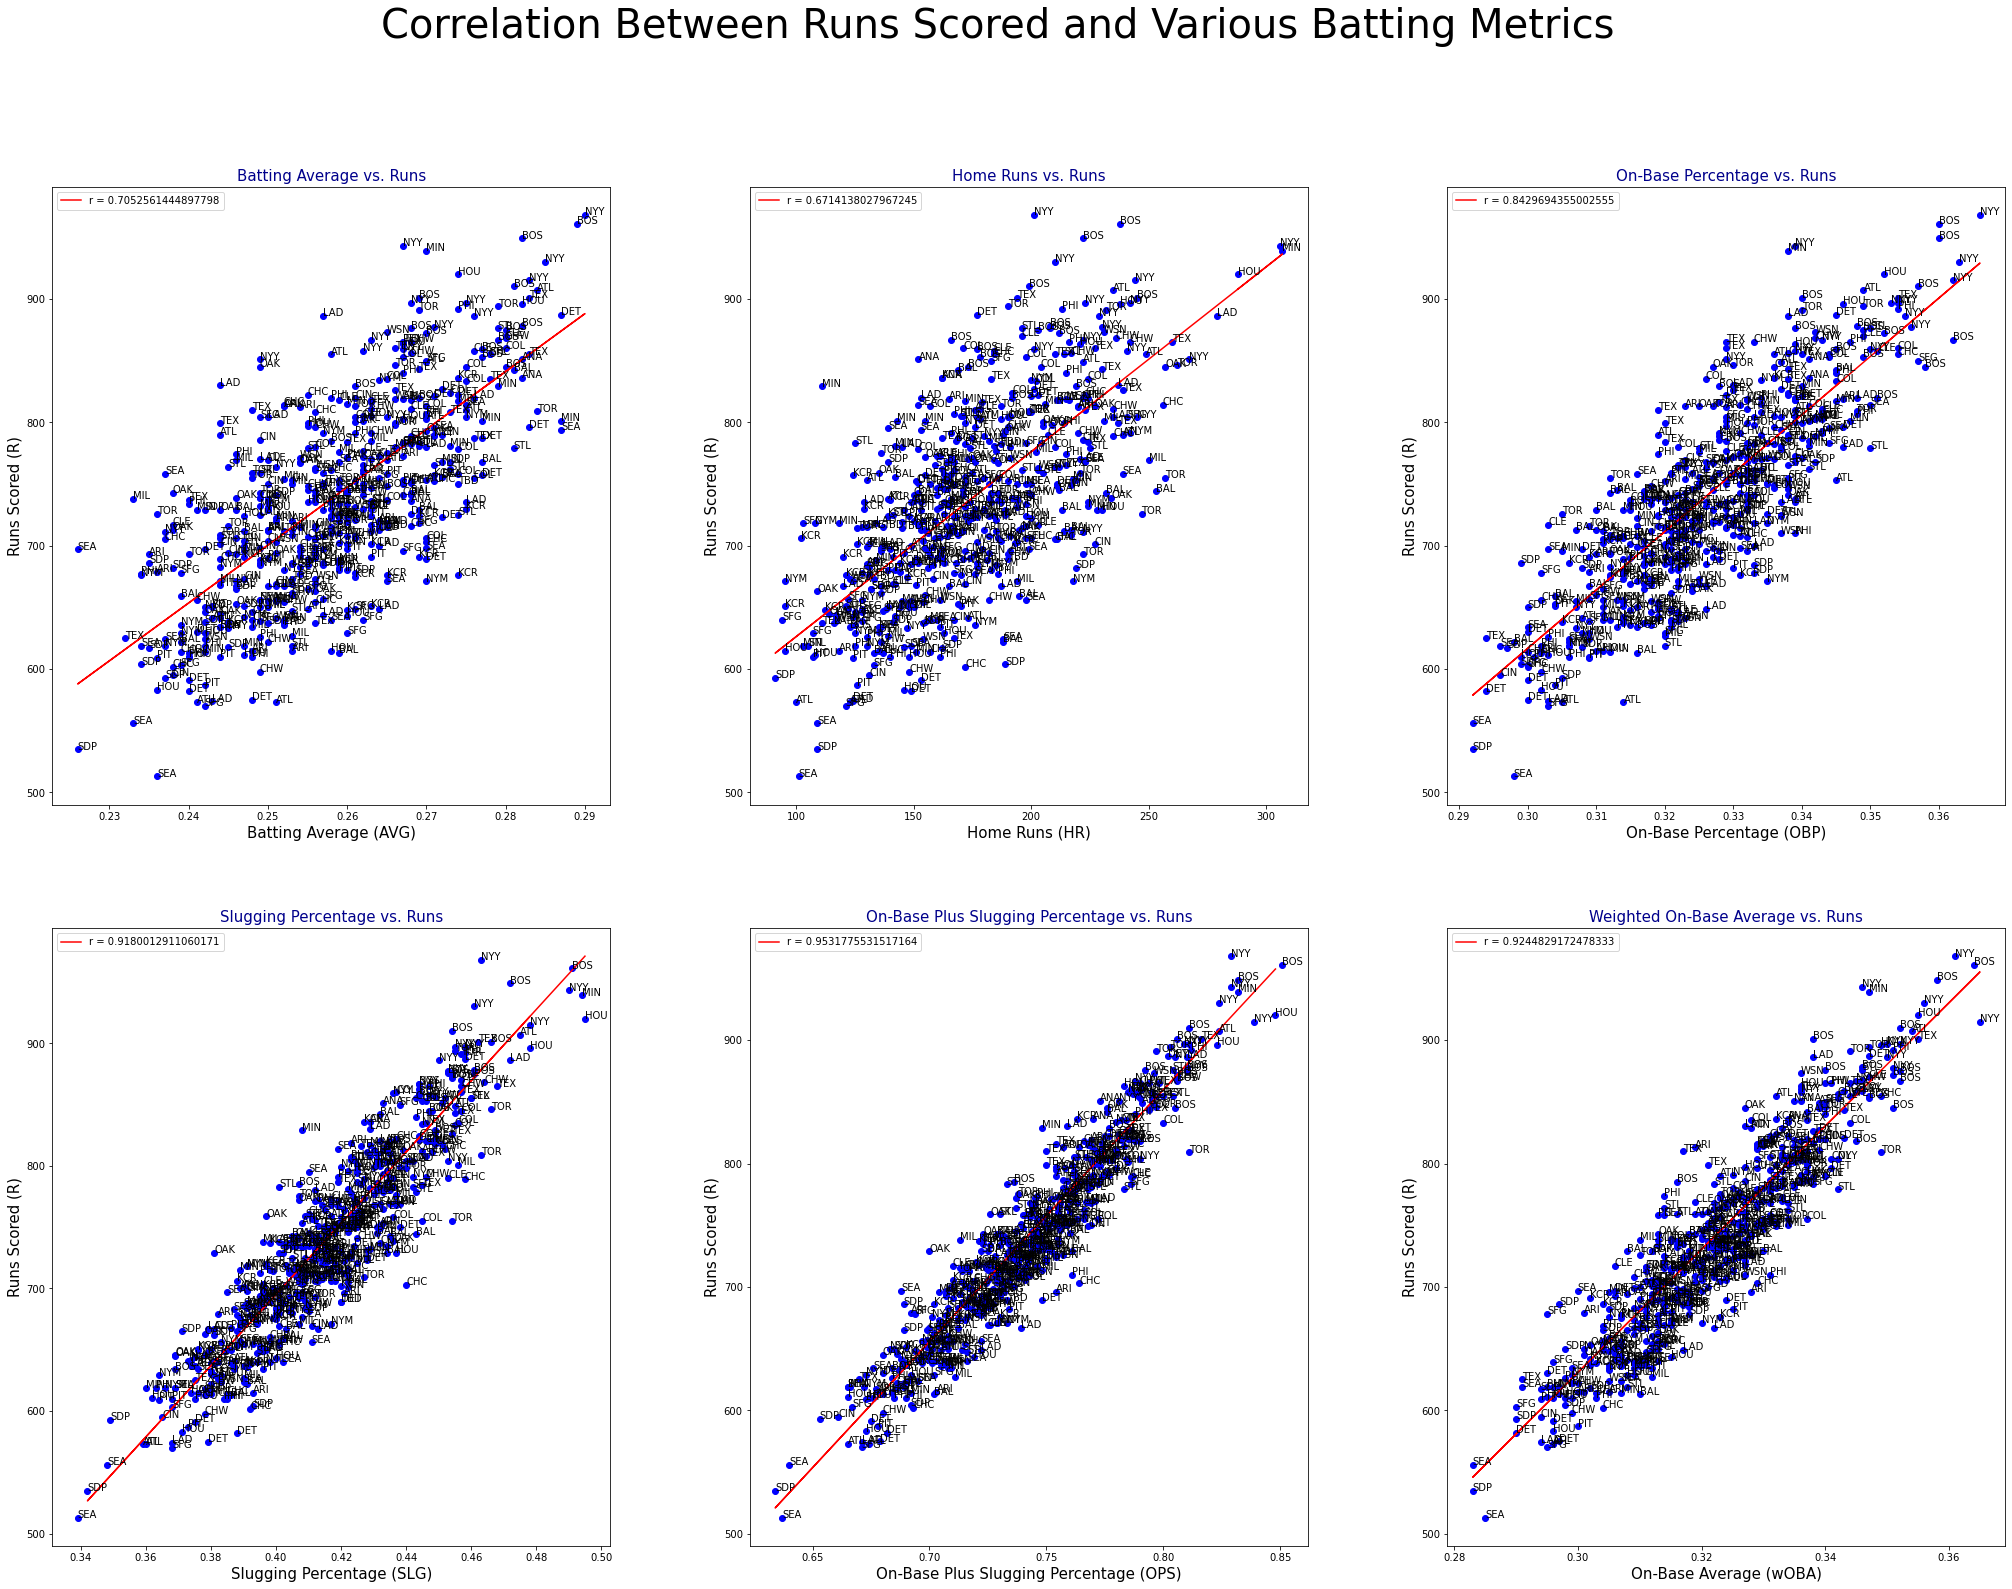

In [205]:
# 2020 was shortened due to COVID, so only 60 regular season games were played meaning less runs were scored,
# so we will ignore that for this exercise
team = team_batting[team_batting.Year != 2020]

fig, ax = plt.subplots(2, 3)
fig.subplots_adjust(wspace=.25)
fig.set_figheight(25)
fig.set_figwidth(35)
fig.suptitle("Correlation Between Runs Scored and Various Batting Metrics", fontsize=40)


######################################################################
#       Plotting Correlation Batting Average vs. Runs Scored         #
######################################################################

plt.sca(ax[0,0])
plt.gca().set_title('Batting Average vs. Runs', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('Batting Average (AVG)', fontsize=15)
plt.gca().set_ylabel('Runs Scored (R)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['AVG'], row['R']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['AVG'].values.reshape(-1,1), team['R'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['AVG'], team['R'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#          Plotting Correlation Home Runs vs. Runs Scored            #
######################################################################

plt.sca(ax[0,1])
plt.gca().set_title('Home Runs vs. Runs', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('Home Runs (HR)', fontsize=15)
plt.gca().set_ylabel('Runs Scored (R)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['HR'], row['R']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['HR'].values.reshape(-1,1), team['R'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['HR'], team['R'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#           Plotting Correlation OBP vs. Runs Scored                 #
######################################################################

plt.sca(ax[0,2])
plt.gca().set_title('On-Base Percentage vs. Runs', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('On-Base Percentage (OBP)', fontsize=15)
plt.gca().set_ylabel('Runs Scored (R)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['OBP'], row['R']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['OBP'].values.reshape(-1,1), team['R'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['OBP'], team['R'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#           Plotting Correlation SLG vs. Runs Scored                 #
######################################################################

plt.sca(ax[1,0])
plt.gca().set_title('Slugging Percentage vs. Runs', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('Slugging Percentage (SLG)', fontsize=15)
plt.gca().set_ylabel('Runs Scored (R)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['SLG'], row['R']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['SLG'].values.reshape(-1,1), team['R'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['SLG'], team['R'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#           Plotting Correlation OPS vs. Runs Scored                 #
######################################################################

plt.sca(ax[1,1])
plt.gca().set_title('On-Base Plus Slugging Percentage vs. Runs', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('On-Base Plus Slugging Percentage (OPS)', fontsize=15)
plt.gca().set_ylabel('Runs Scored (R)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['OPS'], row['R']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['OPS'].values.reshape(-1,1), team['R'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['OPS'], team['R'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#           Plotting Correlation wOBA vs. Runs Scored                #
######################################################################

plt.sca(ax[1,2])
plt.gca().set_title('Weighted On-Base Average vs. Runs', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('On-Base Average (wOBA)', fontsize=15)
plt.gca().set_ylabel('Runs Scored (R)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['wOBA'], row['R']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['wOBA'].values.reshape(-1,1), team['R'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['wOBA'], team['R'], color = 'blue')
plt.legend(loc = 'upper left')

plt.show()

A baseball fan with basic knowledge might be under the assumption that batting average and homeruns can determine whether or not a player is good at hitting. As the plots have shown, this is not exactly the case. At the end of the day, teams want to score runs, regardless of how they do so. The plots, however, show that out of the five metrics we studied, batting average was the least correlated to scoring runs, with a correlation coefficient of just .705. The metric that had the greatest correlation to scoring runs was On-Base Plus Slugging (OPS) with a coefficient of .953.

What we can gather from this is that a player with a high OPS will likely produce more runs for a team than a player who has a high batting average but an OPS close to the batting average. 

For example, say player A gets 3 hits in 10 at-bats but all 3 hits are singles and he gets 0 walks. His batting average is .300, which is good, but his OPS is only .600, which is below average. 

Now say player B gets 3 hits in 10 at-bats but all 3 hits are homeruns and he also walks 3 times. His batting average is also .300, but now his OPS 1.6615, which is almost 3 times better than player A's OPS. Obviously, player B was more productive for his team than player A -- batting average does not show this, but OPS most certainly does.

#### Correlation Between Plate Discipline and Scoring Runs

Now, with OPS, we have an offensive metric that we determined to be highly correlated to scoring runs. Next, we want to determine what metrics are going to correlate to having a high OPS. One of the  most important skills a player can have is plate discipline. In an era where strikeouts are happening at historic rates, having a player with a keen batting eye can be the difference between starting a rally and a rally fizzling out. The metrics we will look at are below:

<br />**BB/K: Walk to Strikeout Rate Rate**
> The rate at which a batter walks compared to stirking out. A value over 1 means that the batter walks more than he strikes out and a value under 1 means that he strikes out more than he walks.

<br />**O-Swing%: Swing Rate on Pitches Outside the Strike Zone**
> The percentage of pitches that are outside of the strike zone that the batter swings at.

<br />**Z-Swing%: Swing Rate on Pitches Inside the Strike Zone**
> The percentage of pitches that are inside of the strike zone that the batter swings at.

<br />**Swing%: Swing Rate**
> The percentage of pitches that the batter swings at.

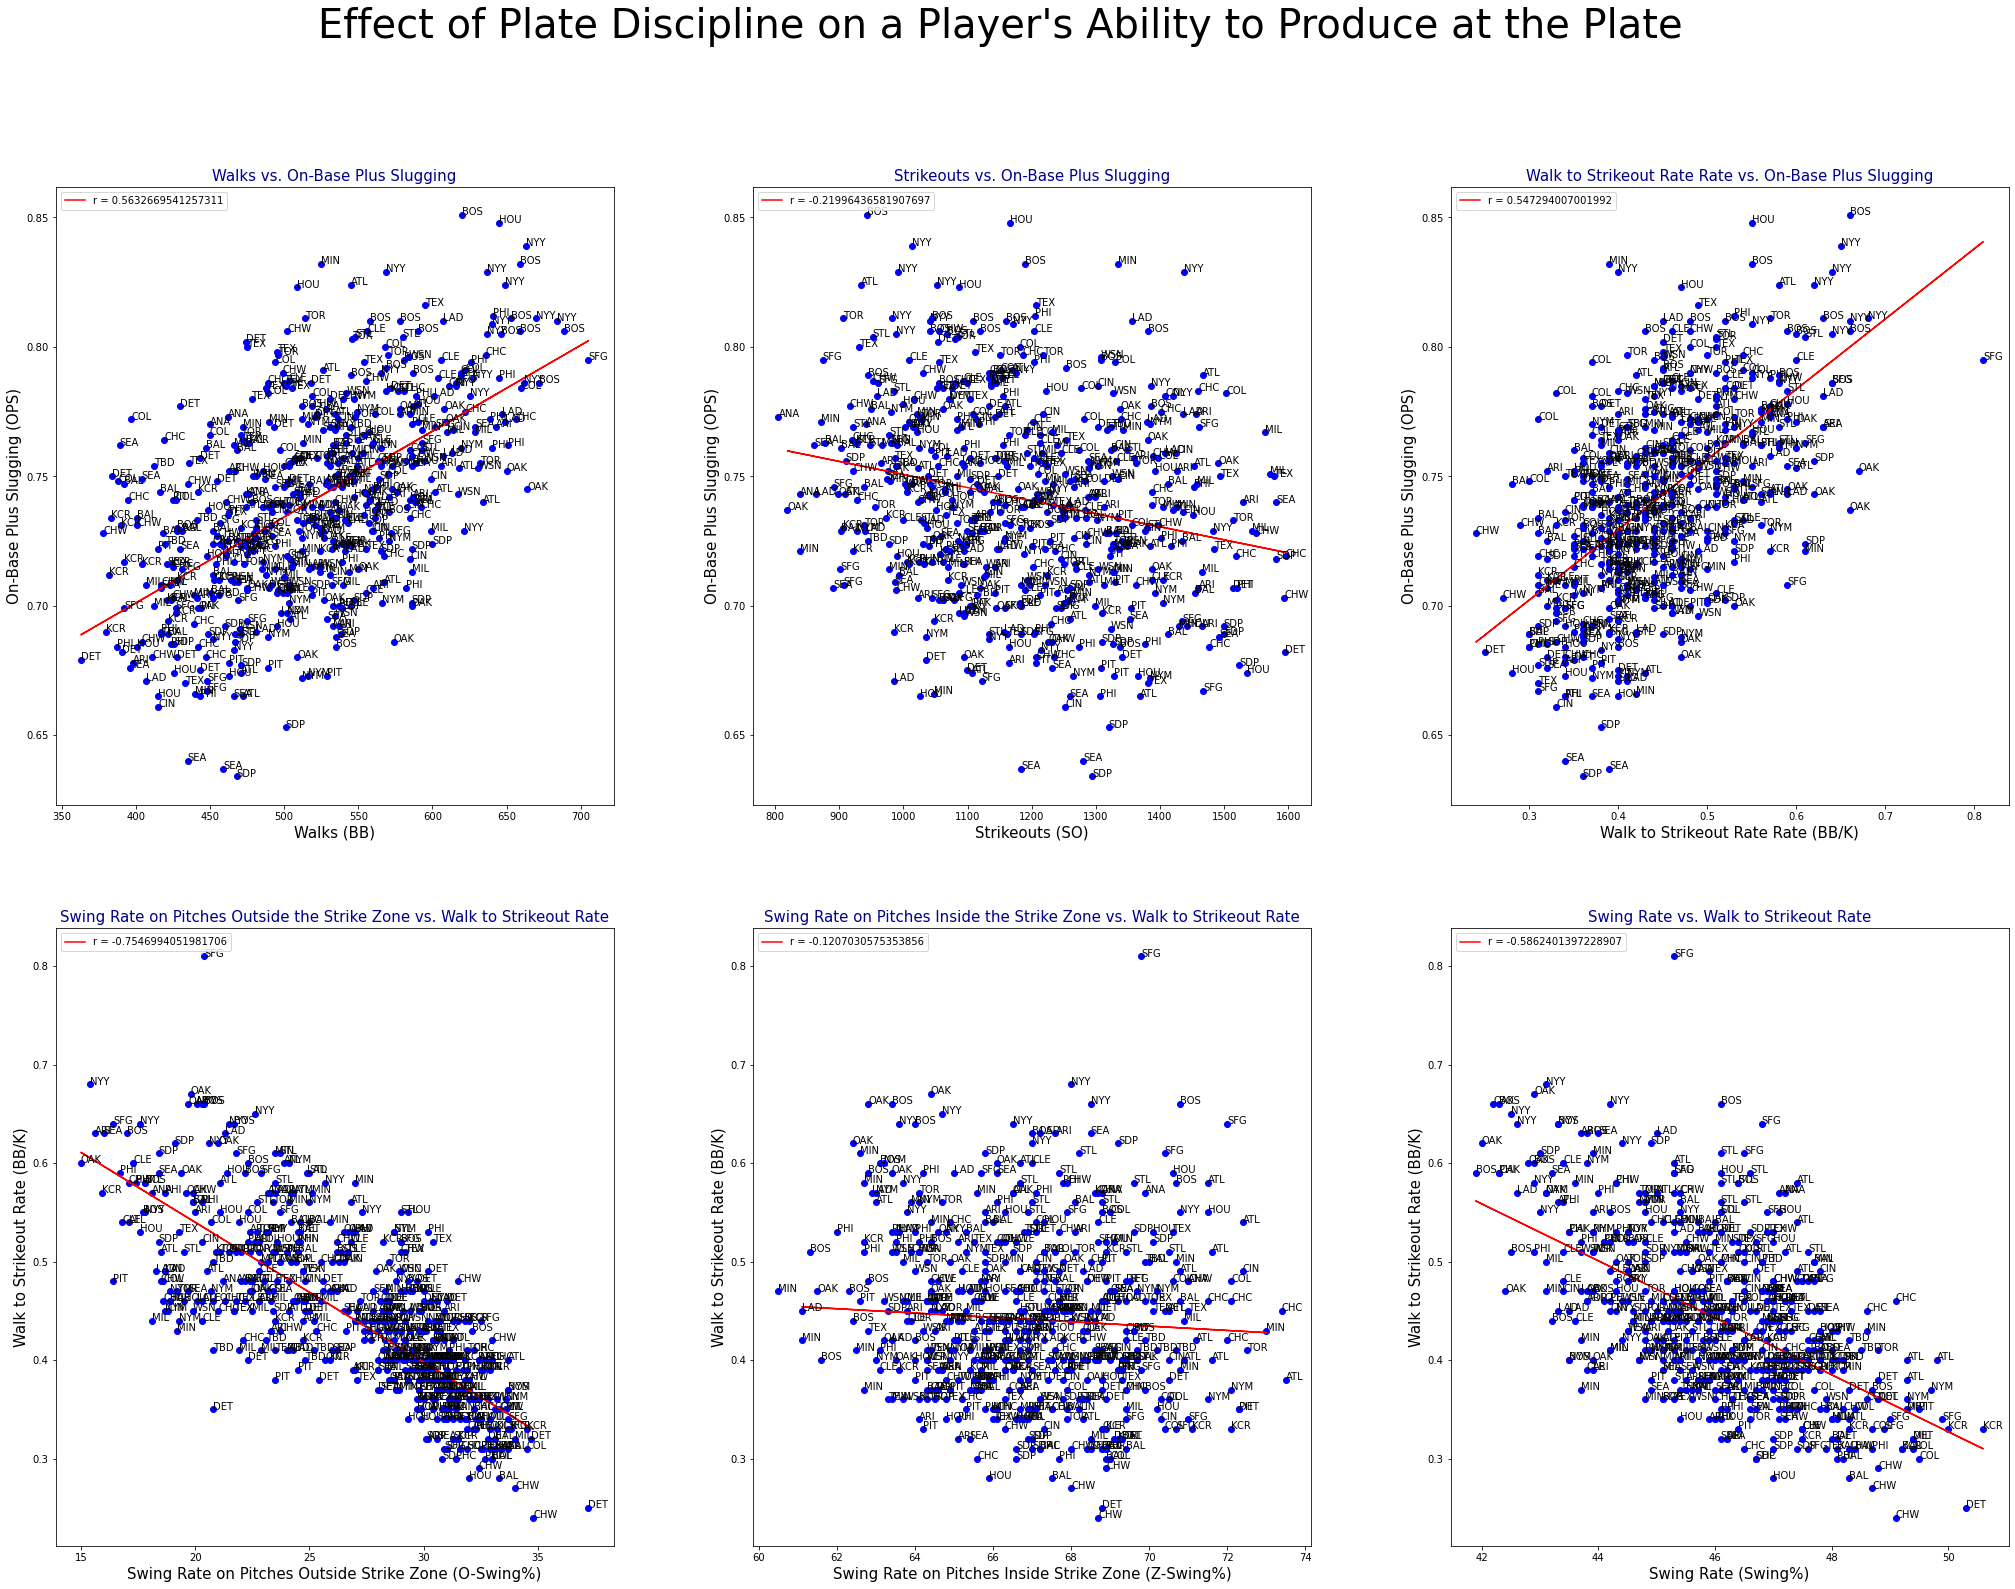

In [207]:
team = team_batting[team_batting.Year != 2020]

fig, ax = plt.subplots(2, 3)
fig.subplots_adjust(wspace=.25)
fig.set_figheight(25)
fig.set_figwidth(35)
fig.suptitle("Effect of Plate Discipline on a Player's Ability to Produce at the Plate", fontsize=40)


######################################################################
#             Plotting Correlation Walks vs. OPS                     #
######################################################################

plt.sca(ax[0,0])
plt.gca().set_title('Walks vs. On-Base Plus Slugging', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('Walks (BB)', fontsize=15)
plt.gca().set_ylabel('On-Base Plus Slugging (OPS)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['BB'], row['OPS']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['BB'].values.reshape(-1,1), team['OPS'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['BB'], team['OPS'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#           Plotting Correlation Strikeouts vs. OPS                  #
######################################################################

plt.sca(ax[0,1])
plt.gca().set_title('Strikeouts vs. On-Base Plus Slugging', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('Strikeouts (SO)', fontsize=15)
plt.gca().set_ylabel('On-Base Plus Slugging (OPS)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['SO'], row['OPS']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['SO'].values.reshape(-1,1), team['OPS'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['SO'], team['OPS'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#               Plotting Correlation BB/K vs. OPS                    #
######################################################################

plt.sca(ax[0,2])
plt.gca().set_title('Walk to Strikeout Rate Rate vs. On-Base Plus Slugging', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('Walk to Strikeout Rate Rate (BB/K)', fontsize=15)
plt.gca().set_ylabel('On-Base Plus Slugging (OPS)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['BB/K'], row['OPS']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['BB/K'].values.reshape(-1,1), team['OPS'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['BB/K'], team['OPS'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#               Plotting Correlation BB/K vs. O-Swing%               #
######################################################################

plt.sca(ax[1,0])
plt.gca().set_title('Swing Rate on Pitches Outside the Strike Zone vs. Walk to Strikeout Rate', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('Swing Rate on Pitches Outside Strike Zone (O-Swing%)', fontsize=15)
plt.gca().set_ylabel('Walk to Strikeout Rate (BB/K)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['O-Swing%'], row['BB/K']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['O-Swing%'].values.reshape(-1,1), team['BB/K'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['O-Swing%'], team['BB/K'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#               Plotting Correlation BB/K vs. Z-Swing%               #
######################################################################

plt.sca(ax[1,1])
plt.gca().set_title('Swing Rate on Pitches Inside the Strike Zone vs. Walk to Strikeout Rate', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('Swing Rate on Pitches Inside Strike Zone (Z-Swing%)', fontsize=15)
plt.gca().set_ylabel('Walk to Strikeout Rate (BB/K)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['Z-Swing%'], row['BB/K']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['Z-Swing%'].values.reshape(-1,1), team['BB/K'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['Z-Swing%'], team['BB/K'], color = 'blue')
plt.legend(loc = 'upper left')

######################################################################
#               Plotting Correlation BB/K vs. Swing%                 #
######################################################################

plt.sca(ax[1,2])
plt.gca().set_title('Swing Rate vs. Walk to Strikeout Rate', fontsize=15, c = 'DarkBlue')
plt.gca().set_xlabel('Swing Rate (Swing%)', fontsize=15)
plt.gca().set_ylabel('Walk to Strikeout Rate (BB/K)', fontsize=15)

# Add labels for each point
for idx, row in team.iterrows():
    plt.annotate(row['Team'], (row['Swing%'], row['BB/K']))
    
# Calculate regression line and plot it in the same graph
model = LinearRegression()
x, y = team['Swing%'].values.reshape(-1,1), team['BB/K'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, train_size=0.3)
model = model.fit(x_train, y_train)
prediction = model.predict(x_test)

# Plot regression line and scatter the data points on the same axis
plt.plot(x_test, prediction, label = f'r = {pearsonr(x.flatten(), y)[0]}', color='red')
plt.scatter(team['Swing%'], team['BB/K'], color = 'blue')
plt.legend(loc = 'upper left')

plt.show()

As the plots show, a batter's strikeout to walk rate is moderately correlated to a player's ability to produce at the plate, as it has a .547 correlation coefficient. Furthermore, after looking at how plate disicpline effects a batter's strikeout to walk rate, we determined that the correlation between a batter having a low BB/K and a batter swinging at pitches outside of the strike zone is strong. In addition, we also found that the more pitches that a batter swings overall will lead to a decrease in BB/K. Through this, we can conclude that in order for a batter to be productive at the plate, it's important for them to make smart swing decisions, meaning that they should be selective of what pitches to swing at; minimizing the number of swings at pitches that are outside of the strike zone is very beneficial to improving BB/K and consequently improving overall production with the bat in their hands.

#### Correlation Matrix for Offensive Metrics 

Building onto what we have done in the last two sections, in this section, I am going to display a correlation matrix for all offensive metrics to provide an even clearer visual into which stats correlate the best to each other, including scoring runs.

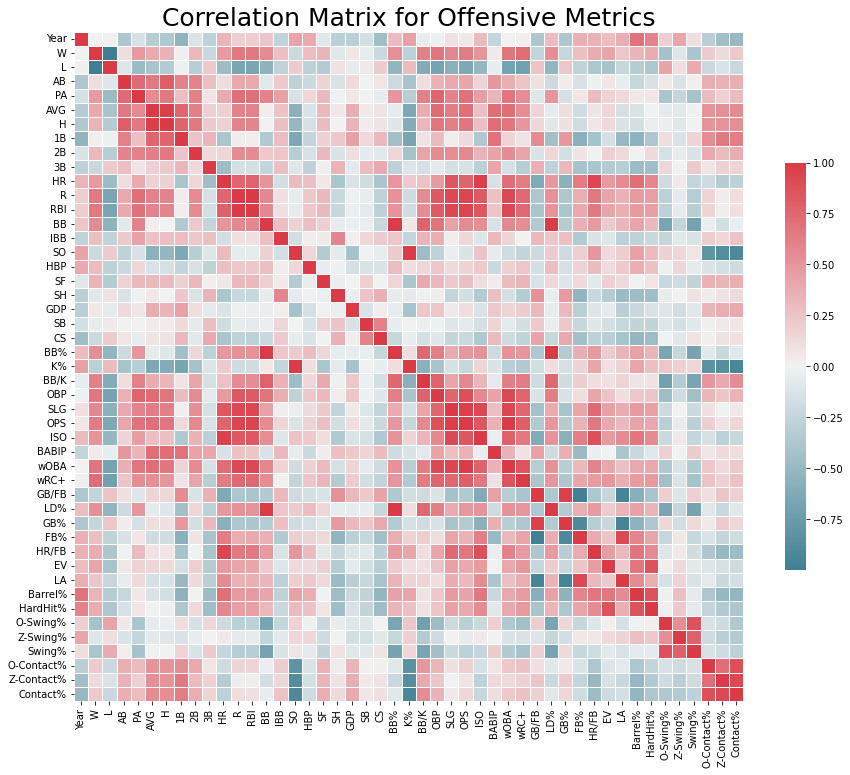

In [11]:
team = team_batting[team_batting.Year != 2020]
team = team[team.Year > 2014]

fig, ax = plt.subplots()
fig.subplots_adjust(wspace=.25)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.title('Correlation Matrix for Offensive Metrics', fontsize=25)

cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
seaborn.heatmap(team.corr(), cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

As we can see from the matrix -- BB/K, OBP, SLG, OPS, and ISO are all strongly correlated to scoring runs, just as we showed in the first section. Below, I will list the metrics that correlate well to the above metrics.

<br />**BB/K: Walk to Strikeout Rate**
> O-Contact%, Z-Contact%, Contact%, wOBA, wRC+, BB%

<br />**OBP: On-Base Percentage**
> LD%, HR/FB, EV, LA, Barrel%, HardHit%, wOBA, wRC+, BB%

<br />**SLG: Slugging Percentage**
> LD%, FB%, HR/FB, EV, LA, Barrel%, HardHit%, wOBA, wRC+, BB%

<br />**OPS: On-Base Plus Slugging**
> LD%, FB%, HR/FB, EV, LA, Barrel%, HardHit%, wOBA, wRC+, BB%

<br />**ISO: Isolated Power**
> LD%, FB%, HR/FB, EV, LA, Barrel%, HardHit%, wOBA, wRC+, BB%

### Part II: Scraping Player Data for 2010-2021 Seasons

Now that we have begun to have an understanding on which stats are the best representives of offensive production, we will now scrape player data from the last decade, clean any missing data, perform an analysis on player's offensive production (instead of team), and then create a model that predicts an All Star appearance based on a player's stats. After we create the model, I will then analyze whether or not a player making the All Star game is related to their offensive production, or if the All Star game is just a popularity vote.

Just like I did above for the team dataframe, I am going to scrape player statistics from Fangraphs (the same categories as I did for the team). In addition, I am going to scrape Cot's Baseball Contracts to obtain player salaries, as well as the Lahman dataset to obtain positions for the players.

#### Scraping Standard Player Data From Fangraphs

In [9]:
pages = [i for i in range(1, 14)]
team_idx = [i for i in range(1, 31)]
teams = ['LAA', 'BAL', 'BOS', 'CHW', 'CLE', 'DET', 'KCR', 'MIN', 'NYY', 'OAK', \
         'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC', 'CIN', 'COL', 'MIA', \
         'HOU', 'LAD', 'MIL', 'WSN', 'NYM', 'PHI', 'PIT', 'STL', 'SDP', 'SFG']
urls = []

for team in team_idx:
    for page in pages:
        urls.append((get_urls(team, (2010, 2021), page, 'player_standard'), teams[team-1]))

count = 0
for url in urls:
    if count == 0:
        player_standard = scraping_FanGraphs(url[0], None, url[1])
        count = 1
    else:
        player_standard = pd.concat([player_standard, scraping_FanGraphs(url[0], None, url[1])])
player_standard

,#,Season,Name,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,Year,Team
0,1,2018,Juan Graterol,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000,None,LAA
1,2,2011,Tyler Chatwood,27,3,5,2,2,0,0,0,1,0,0,0,0,0,0,2,0,0,0,.667,None,LAA
2,3,2011,Gil Velazquez,4,6,7,3,3,0,0,0,0,1,0,0,0,0,1,0,0,0,0,.500,None,LAA
3,4,2011,Ervin Santana,33,2,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,.500,None,LAA
4,5,2012,Jered Weaver,30,2,3,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,.500,None,LAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,570,2021,Conner Menez,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.000,None,SFG
20,571,2021,Caleb Baragar,25,2,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,.000,None,SFG
21,572,2021,Kervin Castro,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.000,None,SFG
22,573,2021,Gregory Santos,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.000,None,SFG


#### Scraping Advanced Player Data From Fangraphs

In [10]:
pages = [i for i in range(1, 14)]
team_idx = [i for i in range(1, 31)]
teams = ['LAA', 'BAL', 'BOS', 'CHW', 'CLE', 'DET', 'KCR', 'MIN', 'NYY', 'OAK', \
         'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC', 'CIN', 'COL', 'MIA', \
         'HOU', 'LAD', 'MIL', 'WSN', 'NYM', 'PHI', 'PIT', 'STL', 'SDP', 'SFG']
urls = []

for team in team_idx:
    for page in pages:
        urls.append((get_urls(team, (2010, 2021), page, 'player_advanced'), teams[team-1]))

count = 0
for url in urls:
    if count == 0:
        player_advanced = scraping_FanGraphs(url[0], None, url[1])
        count = 1
    else:
        player_advanced = pd.concat([player_advanced, scraping_FanGraphs(url[0], None, url[1])])
player_advanced

,#,Season,Name,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,Year,Team
0,1,2015,Jett Bandy,2,0.0%,0.0%,0.00,.500,.500,2.000,2.500,1.500,0.1,.000,0.0,0.0,0.0,1,1.1,1.033,597,None,LAA
1,2,2018,Juan Graterol,1,0.0%,0.0%,0.00,1.000,1.000,1.000,2.000,.000,0.1,1.000,0.0,0.0,0.0,1,0.5,.880,484,None,LAA
2,3,2013,John Hester,1,100.0%,0.0%,1.00,.000,1.000,.000,1.000,.000,2.6,.000,0.0,0.0,0.0,0,0.3,.690,361,None,LAA
3,4,2011,Tyler Chatwood,5,0.0%,0.0%,0.00,.667,.667,.667,1.333,.000,2.6,.667,0.0,0.0,0.0,2,1.1,.594,289,None,LAA
4,5,2010,Ryan Budde,11,9.1%,45.5%,0.20,.400,.455,.800,1.255,.400,1.1,.750,-0.1,0.0,0.0,3,1.8,.530,244,None,LAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,570,2021,Conner Menez,0,0.0%,0.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,0.0,.000,0.0,None,SFG
20,571,2021,Caleb Baragar,2,0.0%,100.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,-0.5,.000,-100,None,SFG
21,572,2021,Kervin Castro,0,0.0%,0.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,0.0,.000,0.0,None,SFG
22,573,2021,Gregory Santos,0,0.0%,0.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,0.0,.000,0.0,None,SFG


#### Scraping Batted Ball Player Data From Fangraphs

In [11]:
pages = [i for i in range(1, 14)]
team_idx = [i for i in range(1, 31)]
teams = ['LAA', 'BAL', 'BOS', 'CHW', 'CLE', 'DET', 'KCR', 'MIN', 'NYY', 'OAK', \
         'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC', 'CIN', 'COL', 'MIA', \
         'HOU', 'LAD', 'MIL', 'WSN', 'NYM', 'PHI', 'PIT', 'STL', 'SDP', 'SFG']
urls = []

for team in team_idx:
    for page in pages:
        urls.append((get_urls(team, (2010, 2021), page, 'player_batted'), teams[team-1]))

count = 0
for url in urls:
    if count == 0:
        player_batted = scraping_FanGraphs(url[0], None, url[1])
        count = 1
    else:
        player_batted = pd.concat([player_batted, scraping_FanGraphs(url[0], None, url[1])])
player_batted

,#,Season,Name,BABIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH,IFH%,BUH,BUH%,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%,Year,Team
0,1,2018,Ryan Schimpf,.000,1.00,0.0%,50.0%,50.0%,0.0%,100.0%,0,0.0%,0,0.0%,0.0%,50.0%,50.0%,50.0%,0.0%,50.0%,None,LAA
1,2,2019,Cesar Puello,.433,4.40,18.2%,66.7%,15.2%,0.0%,60.0%,3,13.6%,0,0.0%,48.5%,33.3%,18.2%,24.2%,36.4%,39.4%,None,LAA
2,3,2010,Ryan Budde,.750,0.00,60.0%,0.0%,40.0%,0.0%,50.0%,0,0.0%,0,0.0%,40.0%,40.0%,20.0%,0.0%,80.0%,20.0%,None,LAA
3,4,2015,Jett Bandy,.000,0.00,0.0%,0.0%,100.0%,0.0%,50.0%,0,0.0%,0,0.0%,50.0%,0.0%,50.0%,0.0%,50.0%,50.0%,None,LAA
4,5,2018,Nolan Fontana,.000,0.33,20.0%,20.0%,60.0%,0.0%,33.3%,0,0.0%,0,0.0%,60.0%,20.0%,20.0%,0.0%,60.0%,40.0%,None,LAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,570,2021,Joey Bart,.500,1.00,50.0%,25.0%,25.0%,0.0%,0.0%,1,100.0%,0,0.0%,0.0%,75.0%,25.0%,50.0%,50.0%,0.0%,None,SFG
20,571,2021,Kervin Castro,.000,0.00,0.0%,0.0%,0.0%,0.0%,0.0%,0,0.0%,0,0.0%,0.0,0.0,0.0,0.0,0.0,0.0,None,SFG
21,572,2021,Gregory Santos,.000,0.00,0.0%,0.0%,0.0%,0.0%,0.0%,0,0.0%,0,0.0%,0.0,0.0,0.0,0.0,0.0,0.0,None,SFG
22,573,2021,Camilo Doval,.000,0.00,0.0%,0.0%,0.0%,0.0%,0.0%,0,0.0%,0,0.0%,0.0,0.0,0.0,0.0,0.0,0.0,None,SFG


#### Scraping Statcast Player Data From Fangraphs

In [12]:
pages = [i for i in range(1, 14)]
team_idx = [i for i in range(1, 31)]
teams = ['LAA', 'BAL', 'BOS', 'CHW', 'CLE', 'DET', 'KCR', 'MIN', 'NYY', 'OAK', \
         'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC', 'CIN', 'COL', 'MIA', \
         'HOU', 'LAD', 'MIL', 'WSN', 'NYM', 'PHI', 'PIT', 'STL', 'SDP', 'SFG']
urls = []

for team in team_idx:
    for page in pages:
        urls.append((get_urls(team, (2010, 2021), page, 'player_statcast'), teams[team-1]))

count = 0
for url in urls:
    if count == 0:
        player_statcast = scraping_FanGraphs(url[0], None, url[1])
        count = 1
    else:
        player_statcast = pd.concat([player_statcast, scraping_FanGraphs(url[0], None, url[1])])
player_statcast

,#,Season,Name,PA,Events,EV,maxEV,LA,Barrels,Barrel%,HardHit,HardHit%,AVG,xBA,SLG,xSLG,wOBA,xwOBA,Year,Team
0,1,2020,Franklin Barreto,18,9,95.6,109.2,10.4,0,0.0%,5,55.6%,.118,0.0,.118,0.0,.139,0.0,None,LAA
1,2,2019,Tyler Skaggs,3,1,95.6,95.6,-36.0,0,0.0%,1,100.0%,.000,0.0,.000,0.0,.230,0.0,None,LAA
2,3,2018,Jabari Blash,45,16,94.6,116.2,17.9,2,12.5%,8,50.0%,.103,0.0,.128,0.0,.163,0.0,None,LAA
3,4,2021,Andrew Heaney,3,1,94.1,94.1,10.2,0,0.0%,0,0.0%,.500,0.0,.500,0.0,.524,0.0,None,LAA
4,5,2018,Joe Hudson,12,12,94.0,103.9,12.8,0,0.0%,7,58.3%,.167,0.0,.250,0.0,.177,0.0,None,LAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,570,2021,Conner Menez,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.000,0.0,.000,0.0,.000,0.0,None,SFG
20,571,2021,Caleb Baragar,2,0,0.0,0.0,0.0,0,0.0,0,0.0,.000,0.0,.000,0.0,.000,0.0,None,SFG
21,572,2021,Kervin Castro,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.000,0.0,.000,0.0,.000,0.0,None,SFG
22,573,2021,Gregory Santos,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,.000,0.0,.000,0.0,.000,0.0,None,SFG


#### Scraping Plate Discipline Player Data From Fangraphs

In [13]:
pages = [i for i in range(1, 14)]
team_idx = [i for i in range(1, 31)]
teams = ['LAA', 'BAL', 'BOS', 'CHW', 'CLE', 'DET', 'KCR', 'MIN', 'NYY', 'OAK', \
         'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC', 'CIN', 'COL', 'MIA', \
         'HOU', 'LAD', 'MIL', 'WSN', 'NYM', 'PHI', 'PIT', 'STL', 'SDP', 'SFG']
urls = []

for team in team_idx:
    for page in pages:
        urls.append((get_urls(team, (2010, 2021), page, 'player_plate_discipline'), teams[team-1]))

count = 0
for url in urls:
    if count == 0:
        player_plate_discipline = scraping_FanGraphs(url[0], None, url[1])
        count = 1
    else:
        player_plate_discipline = pd.concat([player_plate_discipline, scraping_FanGraphs(url[0], None, url[1])])
player_plate_discipline

,#,Season,Name,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,CStr%,CSW%,Year,Team
0,1,2010,Scot Shields,0.0,0.0%,0.0%,0.0,0.0,0.0,100.0%,100.0%,0.0%,100.0%,100.0%,None,LAA
1,2,2010,Brian Fuentes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,LAA
2,3,2010,Fernando Rodney,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,LAA
3,4,2010,Dan Haren,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,LAA
4,5,2010,Ervin Santana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,LAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,570,2012,Clay Hensley,100.0%,50.0%,66.7%,100.0%,100.0%,100.0%,66.7%,100.0%,0.0%,33.3%,33.3%,None,SFG
20,571,2013,Jean Machi,100.0%,100.0%,100.0%,0.0%,50.0%,33.3%,66.7%,100.0%,66.7%,0.0%,66.7%,None,SFG
21,572,2014,Jean Machi,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,50.0%,100.0%,0.0%,0.0%,0.0%,None,SFG
22,573,2018,Roberto Gomez,100.0%,42.9%,50.0%,100.0%,33.3%,50.0%,87.5%,100.0%,25.0%,50.0%,75.0%,None,SFG


#### Merging Dataframes

Now that I have 5 different dataframes for player data, I am going to merge them altogether to get them into one overall dataset.

In [138]:
# Removing Unnecessary Columns
player_standard = player_standard.drop(columns=['#','Year'], errors='ignore')
player_advanced = player_advanced.drop(columns=['#','Year'], errors='ignore')
player_batted = player_batted.drop(columns=['#','Year'], errors='ignore')
player_statcast = player_statcast.drop(columns=['#','Year'], errors='ignore')
player_plate_discipline = player_plate_discipline.drop(columns=['#','Year'], errors='ignore')

player_table = pd.merge(player_standard, player_advanced, on=['Season', 'Name', 'PA', 'AVG', 'Team'])
player_table = pd.merge(player_table, player_batted, on=['Season', 'Name', 'Team', 'BABIP'])
player_table = pd.merge(player_table, player_statcast, on=['Season', 'Name', 'Team', 'AVG', 'PA', 'SLG', 'wOBA'])
player_table = pd.merge(player_table, player_plate_discipline, on=['Season', 'Name', 'Team'])

player_table = player_table.rename(columns={'Season':'Year'})

player_table = player_table.drop_duplicates()

# Removing the % in the values so that they can be used as numbers
player_table['BB%'] = player_table['BB%'].replace({'\%':''}, regex = True)
player_table['K%'] = player_table['K%'].replace({'\%':''}, regex = True)
player_table['LD%'] = player_table['BB%'].replace({'\%':''}, regex = True)
player_table['GB%'] = player_table['GB%'].replace({'\%':''}, regex = True)
player_table['FB%'] = player_table['FB%'].replace({'\%':''}, regex = True)
player_table['HR/FB'] = player_table['HR/FB'].replace({'\%':''}, regex = True)
player_table['Pull%'] = player_table['Pull%'].replace({'\%':''}, regex = True)
player_table['Cent%'] = player_table['Cent%'].replace({'\%':''}, regex = True)
player_table['Oppo%'] = player_table['Oppo%'].replace({'\%':''}, regex = True)
player_table['Soft%'] = player_table['Soft%'].replace({'\%':''}, regex = True)
player_table['Med%'] = player_table['Med%'].replace({'\%':''}, regex = True)
player_table['Hard%'] = player_table['Hard%'].replace({'\%':''}, regex = True)
player_table['Barrel%'] = player_table['Barrel%'].replace({'\%':''}, regex = True)
player_table['HardHit%'] = player_table['HardHit%'].replace({'\%':''}, regex = True)
player_table['O-Swing%'] = player_table['O-Swing%'].replace({'\%':''}, regex = True)
player_table['Z-Swing%'] = player_table['Z-Swing%'].replace({'\%':''}, regex = True)
player_table['Swing%'] = player_table['Swing%'].replace({'\%':''}, regex = True)
player_table['O-Contact%'] = player_table['O-Contact%'].replace({'\%':''}, regex = True)
player_table['Z-Contact%'] = player_table['Z-Contact%'].replace({'\%':''}, regex = True)
player_table['Contact%'] = player_table['Contact%'].replace({'\%':''}, regex = True)
player_table['Zone%'] = player_table['Zone%'].replace({'\%':''}, regex = True)
player_table['F-Strike%'] = player_table['F-Strike%'].replace({'\%':''}, regex = True)
player_table['SwStr%'] = player_table['SwStr%'].replace({'\%':''}, regex = True)
player_table['CStr%'] = player_table['CStr%'].replace({'\%':''}, regex = True)
player_table['CSW%'] = player_table['CSW%'].replace({'\%':''}, regex = True)

player_table = player_table.apply(pd.to_numeric, errors='ignore')

player_table['EV'] = player_table['EV'].replace(0.0, np.NaN)
player_table['LA'] = player_table['LA'].replace(0.0, np.NaN)
player_table['Barrel%'] = player_table['Barrel%'].replace(0.0, np.NaN)

# Select only the columns that we are interested in
player_table = player_table[['Year', 'Name', 'Team', 'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'HBP', 'SO', 'AVG', 'BB/K', 'OBP', 'SLG', 'OPS', 'ISO', 'wOBA', 'wRC+', 'EV', 'LA', 'Barrel%', 'O-Swing%', 'Z-Swing%', 'Swing%', 'SwStr%', 'Contact%']]

# Sort dataframe by Year -- descending
player_table = player_table.sort_values(by='Year')

player_table

,Year,Name,Team,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,HBP,SO,AVG,BB/K,OBP,SLG,OPS,ISO,wOBA,wRC+,EV,LA,Barrel%,O-Swing%,Z-Swing%,Swing%,SwStr%,Contact%
1230,2010,Clay Buchholz,BOS,28,1,1,1,1,0,0,0,0,0,0,0,0,1.000,0.00,1.000,1.000,2.000,0.000,0.895,483.0,NaN,NaN,NaN,0.0,100.0,100.0,0.0,100.0
19521,2010,Brandon Moss,PIT,17,26,27,4,3,1,0,0,2,2,1,0,6,0.154,0.17,0.185,0.192,0.377,0.038,0.172,0.0,NaN,NaN,NaN,33.3,72.3,52.0,8.2,84.3
4721,2010,Ben Revere,MIN,13,28,30,5,5,0,0,0,1,2,2,0,5,0.179,0.40,0.233,0.179,0.412,0.000,0.196,12.0,NaN,NaN,NaN,27.0,59.5,40.0,6.7,83.3
19528,2010,Jason Jaramillo,PIT,33,87,97,13,10,2,0,1,2,6,8,1,14,0.149,0.57,0.227,0.207,0.434,0.057,0.200,18.0,NaN,NaN,NaN,27.4,61.4,43.3,5.2,87.7
9464,2010,Mike McCoy,TOR,46,82,90,16,12,4,0,0,9,3,8,0,20,0.195,0.40,0.267,0.244,0.511,0.049,0.238,40.0,NaN,NaN,NaN,19.5,54.5,37.2,8.3,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369,2021,Nomar Mazara,DET,50,165,181,35,25,5,2,3,12,19,15,0,45,0.212,0.33,0.276,0.321,0.597,0.109,0.264,64.0,90.4,11.1,7.4,33.6,65.4,46.6,11.1,76.2
9424,2021,Cavan Biggio,TOR,79,250,294,56,38,10,1,7,27,27,37,1,78,0.224,0.47,0.322,0.356,0.678,0.132,0.298,84.0,88.9,15.4,5.6,22.2,64.9,41.3,9.7,76.6
3371,2021,Dustin Garneau,DET,20,62,68,13,2,5,0,6,9,11,3,1,18,0.210,0.17,0.250,0.581,0.831,0.371,0.335,113.0,86.4,19.2,10.9,31.6,74.1,48.6,13.1,73.0
3355,2021,Willi Castro,DET,125,413,450,91,61,15,6,9,56,38,23,8,109,0.220,0.21,0.273,0.351,0.624,0.131,0.271,69.0,85.6,11.4,5.2,42.4,76.4,56.3,15.3,72.8


#### Removing Suffix From Player Names

In order to match the names in the Lahman dataset, we will remove the suffix from player names. We do this because I will need to merge data from the Lahman dataset into my dataframe by player name and year. If the player names are not exactly the same, the row will be lost when merging. For example, as you will see below, Cedric Mullins is recorded as Cedric Mullins II on Fangraphs, but I know that he is recorded as Cedric Mullins in the Lahman dataset.

In [139]:
player_table[player_table.Name == 'Cedric Mullins II']

,Year,Name,Team,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,HBP,SO,AVG,BB/K,OBP,SLG,OPS,ISO,wOBA,wRC+,EV,LA,Barrel%,O-Swing%,Z-Swing%,Swing%,SwStr%,Contact%
784,2018,Cedric Mullins II,BAL,45,170,191,40,27,9,0,4,23,11,17,2,37,0.235,0.46,0.312,0.359,0.671,0.124,0.298,86.0,89.3,10.1,3.0,22.2,64.4,40.6,6.9,83.1
910,2019,Cedric Mullins II,BAL,22,64,74,6,4,0,2,0,7,4,4,3,14,0.094,0.29,0.181,0.156,0.337,0.063,0.159,-12.0,84.2,14.9,1.9,33.9,62.0,45.4,10.8,76.1
700,2020,Cedric Mullins II,BAL,48,140,153,38,28,4,3,3,16,12,8,1,37,0.271,0.22,0.315,0.407,0.723,0.136,0.313,95.0,88.6,15.6,2.8,33.0,68.1,48.0,10.0,79.2
658,2021,Cedric Mullins II,BAL,159,602,675,175,103,37,5,30,91,59,59,8,125,0.291,0.47,0.360,0.518,0.878,0.228,0.372,136.0,89.4,14.8,8.1,30.0,64.5,45.1,8.2,81.7


In [140]:
names = player_table.Name.str.split(' ', expand=True)[[0, 1]]
names.columns = ['First', 'Last']
names = names.assign(Name = names.First.str.cat(names.Last,sep=' '))
names = names[['Name']]

player_table = player_table.assign(Name = names.Name.to_list())
player_table[player_table.Name == 'Cedric Mullins']

,Year,Name,Team,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,HBP,SO,AVG,BB/K,OBP,SLG,OPS,ISO,wOBA,wRC+,EV,LA,Barrel%,O-Swing%,Z-Swing%,Swing%,SwStr%,Contact%
784,2018,Cedric Mullins,BAL,45,170,191,40,27,9,0,4,23,11,17,2,37,0.235,0.46,0.312,0.359,0.671,0.124,0.298,86.0,89.3,10.1,3.0,22.2,64.4,40.6,6.9,83.1
910,2019,Cedric Mullins,BAL,22,64,74,6,4,0,2,0,7,4,4,3,14,0.094,0.29,0.181,0.156,0.337,0.063,0.159,-12.0,84.2,14.9,1.9,33.9,62.0,45.4,10.8,76.1
700,2020,Cedric Mullins,BAL,48,140,153,38,28,4,3,3,16,12,8,1,37,0.271,0.22,0.315,0.407,0.723,0.136,0.313,95.0,88.6,15.6,2.8,33.0,68.1,48.0,10.0,79.2
658,2021,Cedric Mullins,BAL,159,602,675,175,103,37,5,30,91,59,59,8,125,0.291,0.47,0.360,0.518,0.878,0.228,0.372,136.0,89.4,14.8,8.1,30.0,64.5,45.1,8.2,81.7


As you can see, the dataset I created from Fangraphs now has only first and last name in the Name column. Now, when I merge dataframes, it will just add a position column to the row that has the correct player name and year.

#### Add Player ID to Player Table from Lahman Dataset

The appearances dataframe (from the Lahman Dataset) only has player ID instead of name. Fangraphs does not have playerIDs, so in order to merge the two together, I had to obtain the playerID that the Lahman Dataset uses from the People dataframe. I then merged the playerID into my dataframe and that allowed me to successfully merge the appearance dataframe.

In [141]:
player_info = pd.read_csv('tables/People.csv')
player_info = player_info[['playerID', 'nameFirst', 'nameLast']]
player_info = player_info.assign(Name = player_info.nameFirst.str.cat(player_info.nameLast,sep=' '))
player_info = player_info[['playerID', 'Name']]

player_table = pd.merge(player_table, player_info, on=['Name'])

#### Add Player's Position to Table

In [142]:
player_pos = pd.read_csv('tables/Appearances.csv')
player_pos = player_pos[['playerID', 'yearID', 'G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_lf', 'G_cf', 'G_rf', 'G_dh']]
player_pos = player_pos[player_pos.yearID > 2010]
player_pos = player_pos.rename(columns = {'yearID':'Year', 'G_p':'P', 'G_c':'C', 'G_1b':'1B', 'G_2b':'2B', 'G_3b':'3B', 'G_ss':'SS', 'G_lf':'LF', 'G_cf':'CF', 'G_rf':'RF', 'G_dh':'DH'})
player_pos = player_pos.astype({'DH':'int32'})

positions = player_pos[['P', 'C', '1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF', 'DH']]

positions = positions.assign(Pos = positions.idxmax(axis=1))

player_pos = pd.merge(player_pos, positions, on = ['P', 'C', '1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF', 'DH'])
player_pos = player_pos[['playerID', 'Year', 'Pos']]
player_pos = player_pos.drop_duplicates()

player_table = pd.merge(player_table, player_pos, on=['playerID', 'Year'])

#### Reorder Columns of Dataframe

In [143]:
# Select only the columns that we are interested in
player_table = player_table[['playerID', 'Year', 'Name', 'Team', 'Pos', 'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'HBP', 'SO', 'AVG', 'BB/K', 'OBP', 'SLG', 'OPS', 'ISO', 'wOBA', 'wRC+', 'EV', 'LA', 'Barrel%', 'O-Swing%', 'Z-Swing%', 'Swing%', 'SwStr%', 'Contact%']]

# Sort dataframe by Year -- descending
player_table = player_table.sort_values(by='Year')

player_table

,playerID,Year,Name,Team,Pos,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,HBP,SO,AVG,BB/K,OBP,SLG,OPS,ISO,wOBA,wRC+,EV,LA,Barrel%,O-Swing%,Z-Swing%,Swing%,SwStr%,Contact%
0,buchhcl01,2011,Clay Buchholz,BOS,P,14,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.00,0.000,0.00,0.000,0.000,0.000,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1264,youngch03,2011,Chris Young,ARI,P,156,567,659,134,73,38,3,20,89,71,80,4,139,0.236,0.58,0.331,0.42,0.751,0.183,0.329,102.0,NaN,NaN,NaN,25.9,61.4,42.5,9.9,76.7
7110,tuckery01,2011,Ryan Tucker,TEX,P,5,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.00,0.000,0.00,0.000,0.000,0.000,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
7111,tobinma01,2011,Mason Tobin,TEX,P,4,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.00,0.000,0.00,0.000,0.000,0.000,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
7112,hambuma01,2011,Mark Hamburger,TEX,P,5,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.00,0.000,0.00,0.000,0.000,0.000,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14892,richatr01,2021,Trevor Richards,MIL,P,15,0,1,0,0,0,0,0,1,0,1,0,0,0.000,1.00,1.000,0.00,1.000,0.000,0.692,339.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
14891,richatr01,2021,Trevor Richards,TBR,P,6,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.00,0.000,0.00,0.000,0.000,0.000,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
11542,godleza01,2021,Zack Godley,MIL,P,2,0,1,0,0,0,0,0,0,0,0,0,0,0.000,0.00,0.000,0.00,0.000,0.000,0.000,-100.0,NaN,NaN,NaN,100.0,0.0,100.0,0.0,100.0
11268,wislema01,2021,Matt Wisler,TBR,P,27,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.00,0.000,0.00,0.000,0.000,0.000,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


#### Remove Pitchers from Dataset

For this project, I will only be focusing on offensive metrics. In the National League (NL), up until 2022 (excluding the special COVID season in 2020), pitchers batted. If an American League (AL) team played an NL team at the NL team's stadium, the DH was not used. As a result, many pitchers have been included in this batting dataset. However, since pitchers are usually terrible at batting, we want to remove them from the dataset so that they do not skew the data. This is especially important when we will take a look at the stats for All Stars; pitchers make the All Star game for being dominant on the mound, not because they can produce at the plate.

In [144]:
player_table = player_table[player_table.Pos != 'P']
player_table

,playerID,Year,Name,Team,Pos,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,HBP,SO,AVG,BB/K,OBP,SLG,OPS,ISO,wOBA,wRC+,EV,LA,Barrel%,O-Swing%,Z-Swing%,Swing%,SwStr%,Contact%
1259,larocad01,2011,Adam LaRoche,WSN,1B,43,151,177,26,19,4,0,3,15,15,25,0,37,0.172,0.68,0.288,0.258,0.546,0.086,0.258,58.0,NaN,NaN,NaN,21.5,62.7,37.7,8.1,78.6
5295,rasmuco01,2011,Colby Rasmus,TOR,CF,35,133,140,23,10,10,0,3,14,13,5,0,39,0.173,0.13,0.201,0.316,0.517,0.143,0.225,33.0,NaN,NaN,NaN,33.7,76.4,51.5,14.1,72.7
5294,rasmuco01,2011,Colby Rasmus,STL,CF,94,338,386,83,52,14,6,11,61,40,45,0,77,0.246,0.58,0.332,0.420,0.753,0.175,0.330,110.0,NaN,NaN,NaN,27.9,72.4,47.1,10.0,78.7
2533,gardnbr01,2011,Brett Gardner,NYY,LF,159,510,588,132,98,19,8,7,87,36,60,8,93,0.259,0.65,0.345,0.369,0.713,0.110,0.321,97.0,NaN,NaN,NaN,21.1,50.6,35.1,3.0,91.4
7118,quintom01,2011,Omar Quintanilla,TEX,2B,11,22,23,1,0,0,1,0,3,2,0,0,9,0.045,0.00,0.045,0.136,0.182,0.091,0.073,-74.0,NaN,NaN,NaN,42.6,64.0,52.9,11.5,78.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11513,rosared01,2021,Eddie Rosario,ATL,LF,33,96,106,26,13,4,2,7,13,16,9,0,14,0.271,0.64,0.330,0.573,0.903,0.302,0.375,133.0,88.2,19.4,9.6,39.5,77.0,54.1,9.2,83.0
14904,hermomi01,2021,Michael Hermosillo,CHC,RF,16,36,38,7,2,2,0,3,5,7,1,1,12,0.194,0.08,0.237,0.500,0.737,0.306,0.307,90.0,89.3,30.4,20.8,31.6,76.7,53.7,18.8,65.0
11533,schwaky01,2021,Kyle Schwarber,BOS,LF,41,134,168,39,22,10,0,7,34,18,33,1,39,0.291,0.85,0.435,0.522,0.957,0.231,0.413,161.0,92.5,17.7,15.8,22.0,66.0,40.6,10.2,74.9
11534,schwaky01,2021,Kyle Schwarber,WSN,LF,72,265,303,67,33,9,0,25,42,53,31,5,88,0.253,0.35,0.340,0.570,0.910,0.317,0.380,136.0,92.2,14.2,18.4,24.1,68.5,41.9,11.5,72.6


#### Add Player Salaries to Dataset

Just as a fun aside, at the end of this project, we will compare a player's salary to whether or not he was an All Star. It will be interesting to see how many players that make top dollar end up not making the All Star game. In order to do that, I have scraped salaries from Cot's Baseball Contracts and placed them in a CSV file so that I could create a dataframe for them. I then merge the salary dataframe onto my player dataframe so that a new column, Salary, is added to the dataframe.

In [145]:
salaries = pd.read_csv('salaries/salaries.csv')

# Split the Name colum into first name and last name (originally stored as 'Last, First')
# and store it as a separate dataframe
names = salaries.Player.str.split(', ', expand=True)[[0, 1]]

# Create a new column called Name that has the format 'First Last'
names = names.assign(Name = names[1].str.cat(names[0],sep=' '))

# Remove all columns except for the new name column
names = names[['Name']]

# Add the years to the names dataframe
names = names.assign(Year = salaries.Year.to_list())

# Add the salaries to the names dataframe
names = names.assign(Salary = salaries.Salary.to_list())

names.Salary = names.Salary.str.replace(',', '')
names.Salary = names.Salary.replace({'\$':''}, regex = True)

# Assign names to the salaries variable
salaries = names

player_table = pd.merge(player_table, salaries, on = ['Name', 'Year'])
player_table

,playerID,Year,Name,Team,Pos,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,HBP,SO,AVG,BB/K,OBP,SLG,OPS,ISO,wOBA,wRC+,EV,LA,Barrel%,O-Swing%,Z-Swing%,Swing%,SwStr%,Contact%,Salary
0,larocad01,2011,Adam LaRoche,WSN,1B,43,151,177,26,19,4,0,3,15,15,25,0,37,0.172,0.68,0.288,0.258,0.546,0.086,0.258,58.0,NaN,NaN,NaN,21.5,62.7,37.7,8.1,78.6,7000000
1,rasmuco01,2011,Colby Rasmus,TOR,CF,35,133,140,23,10,10,0,3,14,13,5,0,39,0.173,0.13,0.201,0.316,0.517,0.143,0.225,33.0,NaN,NaN,NaN,33.7,76.4,51.5,14.1,72.7,443000
2,rasmuco01,2011,Colby Rasmus,STL,CF,94,338,386,83,52,14,6,11,61,40,45,0,77,0.246,0.58,0.332,0.420,0.753,0.175,0.330,110.0,NaN,NaN,NaN,27.9,72.4,47.1,10.0,78.7,443000
3,gardnbr01,2011,Brett Gardner,NYY,LF,159,510,588,132,98,19,8,7,87,36,60,8,93,0.259,0.65,0.345,0.369,0.713,0.110,0.321,97.0,NaN,NaN,NaN,21.1,50.6,35.1,3.0,91.4,529500
4,leeca01,2011,Carlos Lee,HOU,LF,155,585,653,161,101,38,4,18,66,94,59,3,60,0.275,0.98,0.342,0.446,0.788,0.171,0.341,115.0,NaN,NaN,NaN,26.1,64.1,43.7,5.1,88.1,19000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,rosared01,2021,Eddie Rosario,CLE,LF,78,283,306,72,49,15,1,7,29,46,17,1,47,0.254,0.36,0.296,0.389,0.685,0.134,0.295,86.0,88.6,14.1,4.6,38.1,77.1,53.1,9.6,82.0,8000000
5649,rosared01,2021,Eddie Rosario,ATL,LF,33,96,106,26,13,4,2,7,13,16,9,0,14,0.271,0.64,0.330,0.573,0.903,0.302,0.375,133.0,88.2,19.4,9.6,39.5,77.0,54.1,9.2,83.0,8000000
5650,schwaky01,2021,Kyle Schwarber,BOS,LF,41,134,168,39,22,10,0,7,34,18,33,1,39,0.291,0.85,0.435,0.522,0.957,0.231,0.413,161.0,92.5,17.7,15.8,22.0,66.0,40.6,10.2,74.9,7000000
5651,schwaky01,2021,Kyle Schwarber,WSN,LF,72,265,303,67,33,9,0,25,42,53,31,5,88,0.253,0.35,0.340,0.570,0.910,0.317,0.380,136.0,92.2,14.2,18.4,24.1,68.5,41.9,11.5,72.6,7000000


### Part III: Analyzing Offensive Metrics Using Player Data

Now that we have player data, we can further analyze what metrics lead to more production from a player. For the next section, I am going to analyze how batted ball data as well as plate discipline affect a player's offensive production. While I did have this data available for the team dataframe, doing this with the player data allows me to have a larger sample size from which I take the mean from. If I did teams, it would only be 30 samples each year, whereas the player data has hundreds of players each year. I felt it would be more effective and representative to take a larger sample size.

#### Effect of Contact Quality on Production

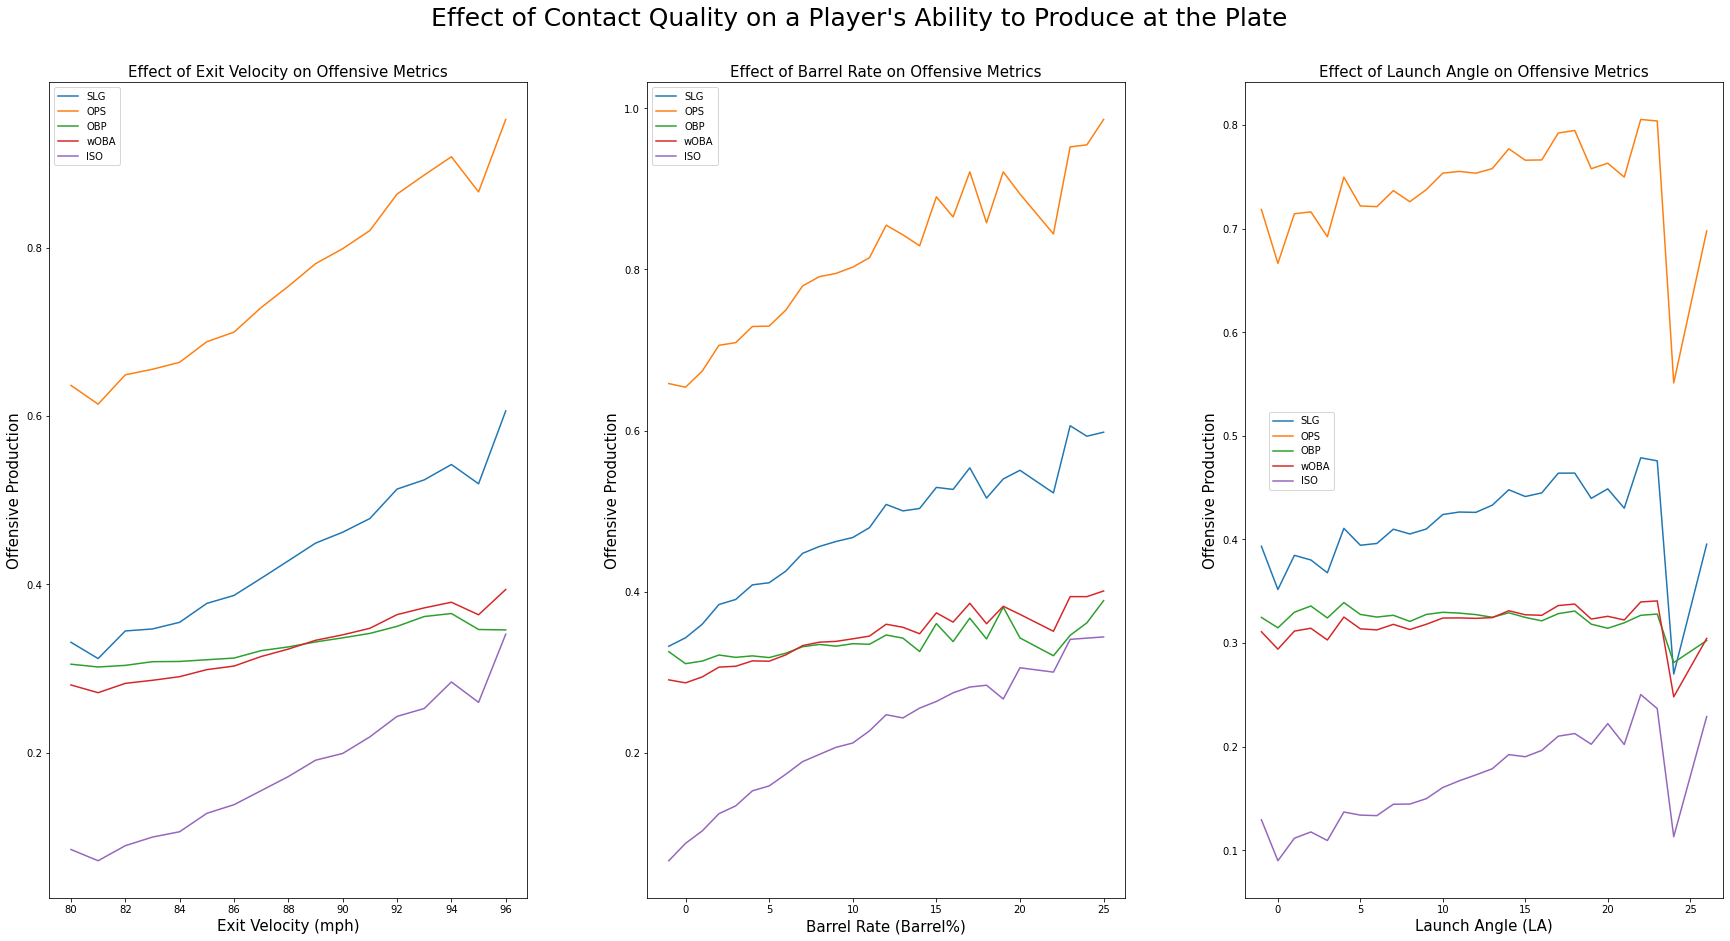

In [149]:
fig, ax = plt.subplots(1, 3)
fig.subplots_adjust(wspace=.25)
fig.set_figheight(15)
fig.set_figwidth(30)
fig.suptitle("Effect of Contact Quality on a Player's Ability to Produce at the Plate", fontsize=25, y=.95)


players = player_table[player_table.PA > 200]
players = players[players.Year > 2014]
players = players.apply(pd.to_numeric, errors='ignore')

######################################################################
#                       Plotting Exit Velocity                       #
######################################################################
velos = [i for i in range(0, 100, 1)]
labels = [i for i in range(0, 99, 1)]

players['Velo'] = pd.cut(players.EV, velos, include_lowest=True, labels = labels)

# Make categorical column (returned by pd.cut) into int -- https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers/61761109#61761109
players['Velo'] = players[['Velo']].apply(lambda col:pd.Categorical(col).codes)

players.groupby('Velo')[['SLG', 'OPS', 'OBP', 'wOBA', 'ISO']].mean().plot(legend=True, ax=ax[0])

# Label the title, x-axis, and y-axis
ax[0].set_title('Effect of Exit Velocity on Offensive Metrics', fontsize=15)
ax[0].set_xlabel("Exit Velocity (mph)", fontsize=15)
ax[0].set_ylabel("Offensive Production", fontsize=15)

plt.xlim([80,96])

######################################################################
#                       Plotting Barrel Rate                         #
######################################################################
velos = [i for i in range(0, 100, 1)]
labels = [i for i in range(0, 99, 1)]

players['Barrel%'] = pd.cut(players['Barrel%'], velos, include_lowest=True, labels = labels)

# Make categorical column (returned by pd.cut) into int -- https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers/61761109#61761109
players['Barrel%'] = players[['Barrel%']].apply(lambda col:pd.Categorical(col).codes)

players.groupby('Barrel%')[['SLG', 'OPS', 'OBP', 'wOBA', 'ISO']].mean().plot(legend=True, ax=ax[1])

# Label the title, x-axis, and y-axis
ax[1].set_title('Effect of Barrel Rate on Offensive Metrics', fontsize=15)
ax[1].set_xlabel("Barrel Rate (Barrel%)", fontsize=15)
ax[1].set_ylabel("Offensive Production", fontsize=15)

######################################################################
#                       Plotting Launch Angle                        #
######################################################################
velos = [i for i in range(0, 100, 1)]
labels = [i for i in range(0, 99, 1)]

players['LA'] = pd.cut(players['LA'], velos, include_lowest=True, labels = labels)

# Make categorical column (returned by pd.cut) into int -- https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers/61761109#61761109
players['LA'] = players[['LA']].apply(lambda col:pd.Categorical(col).codes)

players.groupby('LA')[['SLG', 'OPS', 'OBP', 'wOBA', 'ISO']].mean().plot(ax=ax[2])

# Label the title, x-axis, and y-axis
ax[2].set_title('Effect of Launch Angle on Offensive Metrics', fontsize=15)
ax[2].set_xlabel("Launch Angle (LA)", fontsize=15)
ax[2].set_ylabel("Offensive Production", fontsize=15)
ax[2].legend(loc=(.05,.5))

plt.xlim([-2,27])

# Display the plot
plt.show()

As I expected, as exit velo and barrrel rate increase, so does a player's production. The same goes for launch angle, however, of course, offensive production starts to plateau around the 23-degree mark; this makes sense as the higher the launch angle, the more arc in the trajectory -- at a certain point, too much arc will result in easy pop-outs and flyouts.

#### Effect of Plate Discipline on Production

Next, I will plot plate discipline and how it affects offensive production. I would expect that a player who is more discipline will be able to work counts to get in spots where he gets a good pitch to hit, thus increasing his chances of producing at the plate and driving in runs. In this plot, I will once again focus on O-Swing%, SwStr%, Contact%, and BB/K.

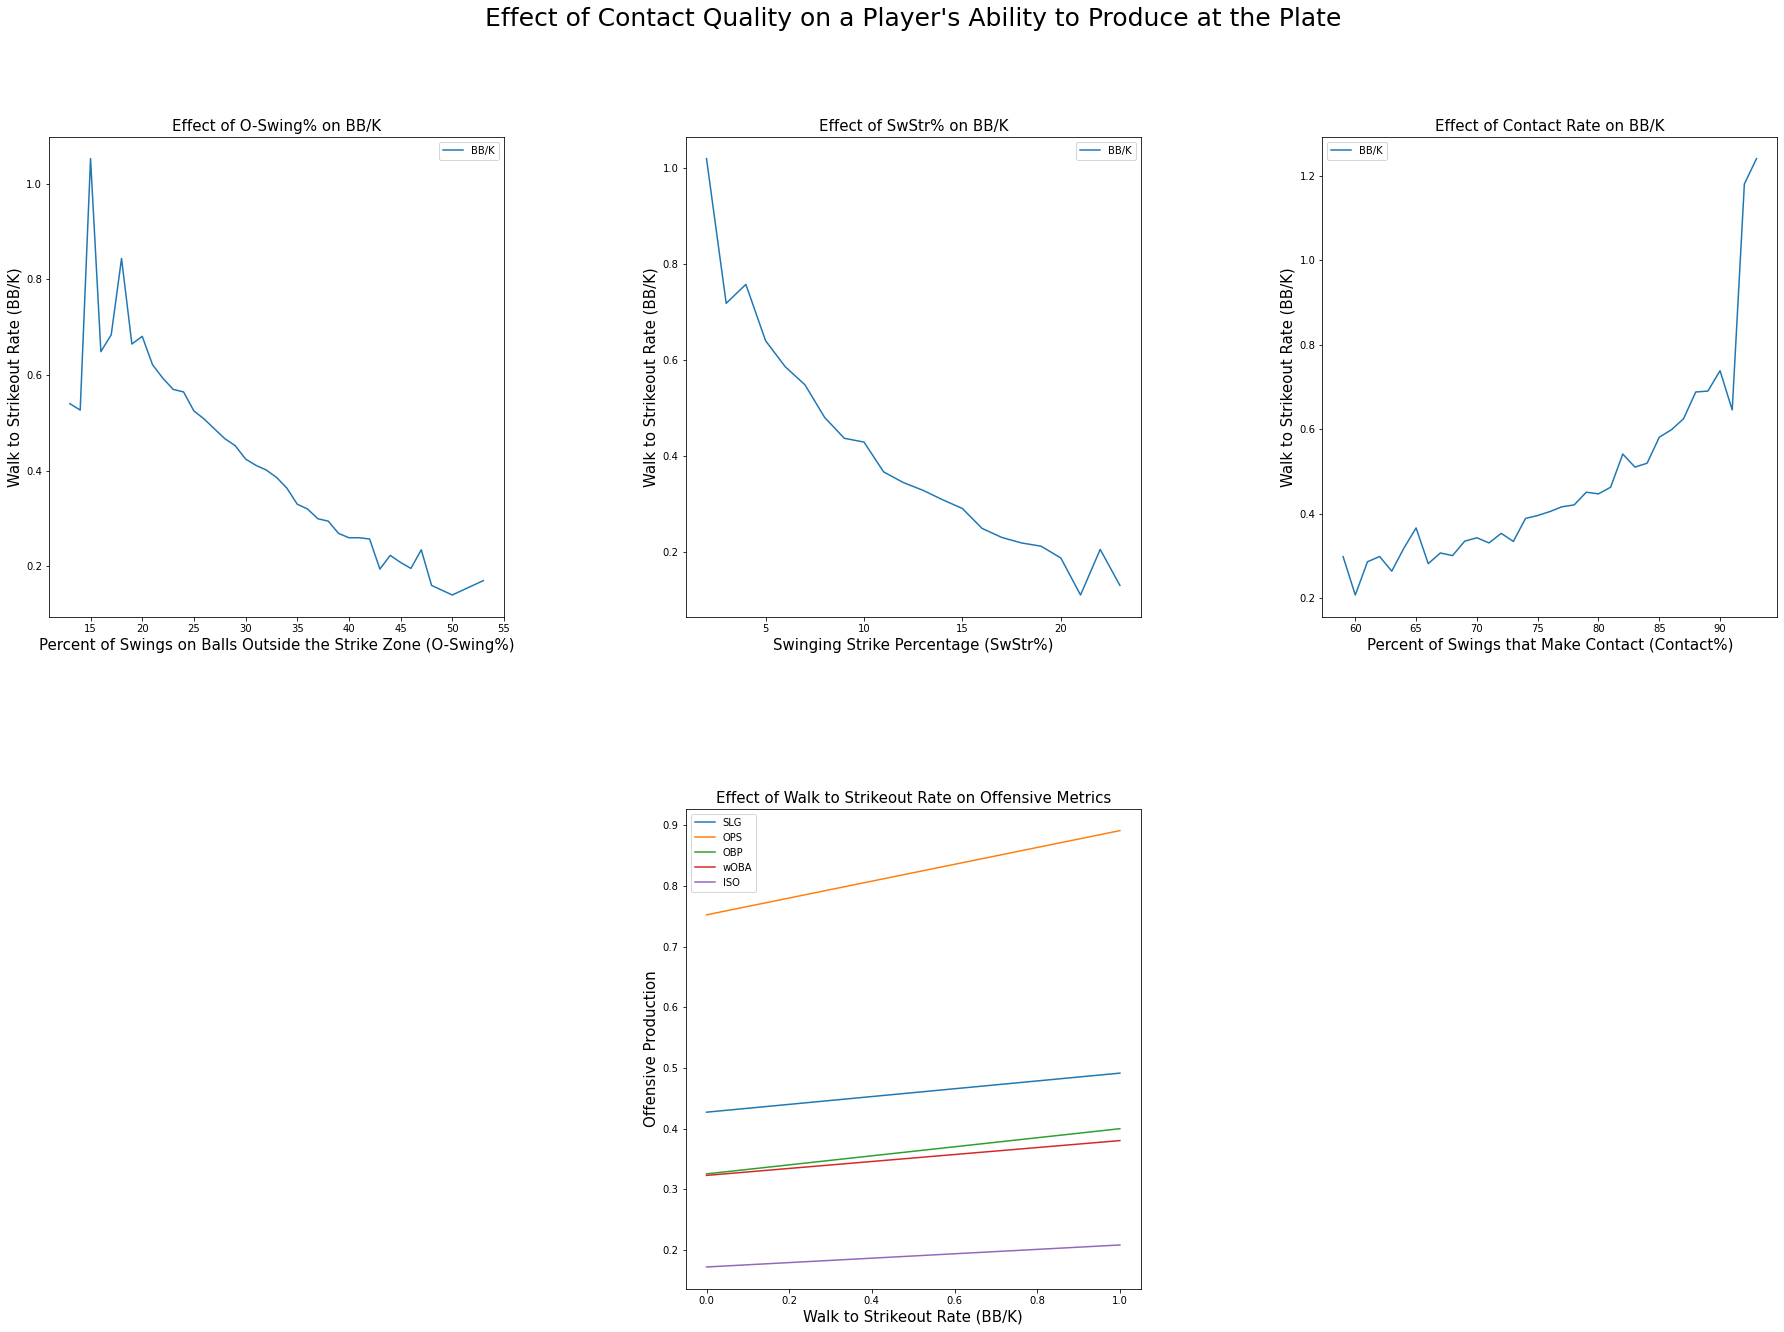

In [150]:
fig, ax = plt.subplots(2, 3)
fig.subplots_adjust(wspace=.25)
fig.set_figheight(20)
fig.set_figwidth(30)
fig.delaxes(ax[1,0])
fig.delaxes(ax[1,2])
fig.suptitle("Effect of Contact Quality on a Player's Ability to Produce at the Plate", fontsize=25, y=.99)


players = player_table[player_table.PA > 200]
players = players[players.Year > 2014]
players = players.apply(pd.to_numeric, errors='ignore')

######################################################################
#                         Plotting O-Swing%                          #
######################################################################
velos = [i for i in range(0, 100, 1)]
labels = [i for i in range(0, 99, 1)]

players['O-Swing%'] = pd.cut(players['O-Swing%'], velos, include_lowest=True, labels = labels)

# Make categorical column (returned by pd.cut) into int -- https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers/61761109#61761109
players['O-Swing%'] = players[['O-Swing%']].apply(lambda col:pd.Categorical(col).codes)

players.groupby('O-Swing%')[['BB/K']].mean().plot(legend=True, ax=ax[0,0])

# Label the title, x-axis, and y-axis
ax[0,0].set_title('Effect of O-Swing% on BB/K', fontsize=15)
ax[0,0].set_xlabel("Percent of Swings on Balls Outside the Strike Zone (O-Swing%)", fontsize=15)
ax[0,0].set_ylabel("Walk to Strikeout Rate (BB/K)", fontsize=15)

######################################################################
#                  Plotting Swinging Strike Percentage               #
######################################################################
velos = [i for i in range(0, 100, 1)]
labels = [i for i in range(0, 99, 1)]

players['SwStr%'] = pd.cut(players['SwStr%'], velos, include_lowest=True, labels = labels)

# Make categorical column (returned by pd.cut) into int -- https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers/61761109#61761109
players['SwStr%'] = players[['SwStr%']].apply(lambda col:pd.Categorical(col).codes)

players.groupby('SwStr%')[['BB/K']].mean().plot(legend=True, ax=ax[0,1])

# Label the title, x-axis, and y-axis
ax[0,1].set_title('Effect of SwStr% on BB/K', fontsize=15)
ax[0,1].set_xlabel("Swinging Strike Percentage (SwStr%)", fontsize=15)
ax[0,1].set_ylabel("Walk to Strikeout Rate (BB/K)", fontsize=15)

######################################################################
#                         Plotting Contact%                          #
######################################################################
velos = [i for i in range(0, 100, 1)]
labels = [i for i in range(0, 99, 1)]

players['Contact%'] = pd.cut(players['Contact%'], velos, include_lowest=True, labels = labels)

# Make categorical column (returned by pd.cut) into int -- https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers/61761109#61761109
players['Contact%'] = players[['Contact%']].apply(lambda col:pd.Categorical(col).codes)

players.groupby('Contact%')[['BB/K']].mean().plot(legend=True, ax=ax[0,2])

# Label the title, x-axis, and y-axis
ax[0,2].set_title('Effect of Contact Rate on BB/K', fontsize=15)
ax[0,2].set_xlabel("Percent of Swings that Make Contact (Contact%)", fontsize=15)
ax[0,2].set_ylabel("Walk to Strikeout Rate (BB/K)", fontsize=15)

######################################################################
#                         Plotting BB/K                              #
######################################################################
velos = [i for i in range(0, 100, 1)]
labels = [i for i in range(0, 99, 1)]

players['BB/K'] = pd.cut(players['BB/K'], velos, include_lowest=True, labels = labels)

# Make categorical column (returned by pd.cut) into int -- https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers/61761109#61761109
players['BB/K'] = players[['BB/K']].apply(lambda col:pd.Categorical(col).codes)

players.groupby('BB/K')[['SLG', 'OPS', 'OBP', 'wOBA', 'ISO']].mean().plot(legend=True, ax=ax[1,1])

# Label the title, x-axis, and y-axis
ax[1,1].set_title('Effect of Walk to Strikeout Rate on Offensive Metrics', fontsize=15)
ax[1,1].set_xlabel("Walk to Strikeout Rate (BB/K)", fontsize=15)
ax[1,1].set_ylabel("Offensive Production", fontsize=15)

plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

# Display the plot
plt.show()

As I suspected, there is a direct relationship between plate discipline and offensive production. In the top 3 plots, I plotted 3 different plate measurements of plate discipline in regards to BB/K. The plots show that the more selective a player is, the more likely he is to more walks and strike out less. For example, the less a player swings at pitches outside the strike zone, the higher his walk to strikeout rate will be. Same with the number of swinging strikes that are made against him. And then, for contact rate, the more contact the player makes, the more likely he is to get base hits, foul off tough pitches, and avoid striking out. Then, to put it all together, I showed that BB/K has a direct correlation to offensive production. In fact, BB/K was even stronger with OPS, which was the metric we determined to be most correlated to scoring runs.

### Part IV: Creating a Model to Predict All Star Seasons

Now that I have completed the analysis offensive production, I am going to use what we have learned thus far and determine whether or not All Stars are actually the top performers or if the All Star nominations are simply a popularity contest. First, I am going to scrape the AllStar Full dataframe from the Lahman Dataset and then merge them into my dataframe, with the value of 1 representing an All Star nomination and 0 representing no All Star nomination. After I have competed that, I will create a predictive model that will be able to predict, using the stats in the dataframe, whether a certain stat line is going to get an All Star nomination.

In [151]:
# Create dataframe from csv file
allstars = pd.read_csv('tables/AllstarFull.csv')

# Remove all rows before the year 2011
allstars = allstars[all_stars.yearID > 2010].reset_index(drop=True)

# Rename yearID column to Year
allstars = allstars.rename(columns = {'yearID':'Year'})

# Take only the columns we need
allstars = allstars[['playerID', 'Year']]

# Add column that says all of these players are all stars
allstars = allstars.assign(All_Star = 1)

# Display resulting dataframe
allstars

,playerID,Year,All_Star
0,weaveje02,2011,1
1,avilaal01,2011,1
2,gonzaad01,2011,1
3,canoro01,2011,1
4,beltrad01,2011,1
...,...,...,...
763,turneju01,2021,1
764,turnetr01,2021,1
765,walketa01,2021,1
766,wheelza01,2021,1


Now that we have a dataframe of all of the All Stars from 2011-present, I will merge it into my player dataframe. All players that are in the All Star dataframe will have an All_Star value of 1, and the rest will have an All_Star value of 0. Then, using the modified dataframe, I will perform Linear Discriminant Analysis to model whether or not a certain statline will be nominated for the All Star game.

#### Merge Allstar Dataframe Onto Players Dataframe

In [152]:
# Merge allstar column onto the player table by playerID and Year. Any row not in allstars will be filled with NaN
player_table = pd.merge(player_table, allstars, how="left", on=['playerID', 'Year'])

# All NaN players were not All Stars that year, so replace NaN with 0
player_table['All_Star'] = player_table['All_Star'].replace(np.NaN, 0)

# Display table
player_table

,playerID,Year,Name,Team,Pos,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,HBP,SO,AVG,BB/K,OBP,SLG,OPS,ISO,wOBA,wRC+,EV,LA,Barrel%,O-Swing%,Z-Swing%,Swing%,SwStr%,Contact%,Salary,All_Star
0,larocad01,2011,Adam LaRoche,WSN,1B,43,151,177,26,19,4,0,3,15,15,25,0,37,0.172,0.68,0.288,0.258,0.546,0.086,0.258,58.0,NaN,NaN,NaN,21.5,62.7,37.7,8.1,78.6,7000000,0.0
1,rasmuco01,2011,Colby Rasmus,TOR,CF,35,133,140,23,10,10,0,3,14,13,5,0,39,0.173,0.13,0.201,0.316,0.517,0.143,0.225,33.0,NaN,NaN,NaN,33.7,76.4,51.5,14.1,72.7,443000,0.0
2,rasmuco01,2011,Colby Rasmus,STL,CF,94,338,386,83,52,14,6,11,61,40,45,0,77,0.246,0.58,0.332,0.420,0.753,0.175,0.330,110.0,NaN,NaN,NaN,27.9,72.4,47.1,10.0,78.7,443000,0.0
3,gardnbr01,2011,Brett Gardner,NYY,LF,159,510,588,132,98,19,8,7,87,36,60,8,93,0.259,0.65,0.345,0.369,0.713,0.110,0.321,97.0,NaN,NaN,NaN,21.1,50.6,35.1,3.0,91.4,529500,0.0
4,leeca01,2011,Carlos Lee,HOU,LF,155,585,653,161,101,38,4,18,66,94,59,3,60,0.275,0.98,0.342,0.446,0.788,0.171,0.341,115.0,NaN,NaN,NaN,26.1,64.1,43.7,5.1,88.1,19000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5650,rosared01,2021,Eddie Rosario,CLE,LF,78,283,306,72,49,15,1,7,29,46,17,1,47,0.254,0.36,0.296,0.389,0.685,0.134,0.295,86.0,88.6,14.1,4.6,38.1,77.1,53.1,9.6,82.0,8000000,0.0
5651,rosared01,2021,Eddie Rosario,ATL,LF,33,96,106,26,13,4,2,7,13,16,9,0,14,0.271,0.64,0.330,0.573,0.903,0.302,0.375,133.0,88.2,19.4,9.6,39.5,77.0,54.1,9.2,83.0,8000000,0.0
5652,schwaky01,2021,Kyle Schwarber,BOS,LF,41,134,168,39,22,10,0,7,34,18,33,1,39,0.291,0.85,0.435,0.522,0.957,0.231,0.413,161.0,92.5,17.7,15.8,22.0,66.0,40.6,10.2,74.9,7000000,1.0
5653,schwaky01,2021,Kyle Schwarber,WSN,LF,72,265,303,67,33,9,0,25,42,53,31,5,88,0.253,0.35,0.340,0.570,0.910,0.317,0.380,136.0,92.2,14.2,18.4,24.1,68.5,41.9,11.5,72.6,7000000,1.0


#### Predictive Model Disregarding Name and Team

First, I am going to completely remove any personal information (Name, Team, Position) and only make a model using the actual stats. If the All Star game is not just a popularity contest, a model that disregards personal information should score pretty highly and be able to predict whether a player's statline warrants a All Star nomination fairly accurately.

In [177]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# The All Star game was not held in 2020 due to COVID so do not include this year in data
players = player_table[player_table.Year != 2020]

# Drop the playerID column because we don't need it
players = players.drop(['playerID'], axis=1)

# Drop categorical columns
players = players.drop(['Name'], axis=1)
players = players.drop(['Team'], axis=1)
players = players.drop(['Pos'], axis=1)

# Remove any rows that have Null data...for example, prior to 2015, statcast data did not exist so players before this are not useable because it can't calculate we a null value
players = players[~players.isnull().any(axis=1)]

# Select our x and y variables for the model
x = players.drop('All_Star', axis=1).values
y = players['All_Star'].values

# Splitting data into test and train data (holdout validation)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3, test_size=0.3)

# Create the Linear Discriminant Analysis model
model = LinearDiscriminantAnalysis()

# Fit the model to the training data
model = model.fit(x_train, y_train)

print(f'Model Success Rate: {model.score(x_test, y_test)}\n')

Model Success Rate: 0.934052757793765



I have printed out the model score, which tells us the percent of players the predictive model got right when predicting whether each player would make the All Star game or not. A success rate of 93% is excellent, and tells us that overall, using just the statline, the model can predict fairly accurately whether a player will get a nomination or not.

#### Predictive Model Disregarding Just Team

We want to find out whether a player's popularity has any impact on them getting an All Star nomination, so we will eliminate the Team information and one-hot encode the player names, so that the model can use the player names as a field to build their predictions off of. The reason I am looking at names is because if a player is continually voted into the ASG, then either, they are consistently good, or they have a good reputation with all fanbases and everybody votes for them. For example, Mike Trout, one of the greatest players in the world, likely even history of MLB, is consistently in the ASG. A lot of this is due to the fact that he is really good. However, last year, he made the ASG, which is held in July, even though he had been out with an injury since early May. The reason for this is because Mike Trout is a household name, and his reputation alone warranted a nomination. If name has an impact on nominations, this model should be able to predict nominations at a higher rate than our previous model.

In [176]:
# The All Star game was not held in 2020 due to COVID so do not include this year in data
players = player_table[player_table.Year != 2020]

# Drop the playerID column because we don't need it
players = players.drop(['playerID'], axis=1)

# One-Hot Encode the names of players
ohe = OneHotEncoder()
data = ohe.fit_transform(players[['Name']])
players[ohe.categories_[0]] = data.toarray()

# Drop categorical columns
players = players.drop(['Name'], axis=1)
players = players.drop(['Team'], axis=1)
players = players.drop(['Pos'], axis=1)

# Remove any rows that have Null data...for example, prior to 2015, statcast data did not exist so players before this are not useable because it can't calculate we a null value
players = players[~players.isnull().any(axis=1)]

# Select our x and y variables for the model
x = players.drop('All_Star', axis=1).values
y = players['All_Star'].values

# Splitting data into test and train data (holdout validation)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3, test_size=0.3)

# Create the Linear Discriminant Analysis model
model = LinearDiscriminantAnalysis()

# Fit the model to the training data
model = model.fit(x_train, y_train)

print(f'Model Success Rate: {model.score(x_test, y_test)}\n')

Model Success Rate: 0.919664268585132



The success rate of this model is still very high, however, it is not significantly better than our original model, so we would presume that including a player's name into the model structure has no real impact, which means that most voting fans likely don't consider the actual player they're voting for, but just the statline. Obviously, it is still possible that it can vary for certain players; for example, if a specific player is known to be dislikeable around the league, the player's name (personality) might be considered over the statline. It just isn't wide spread the reason for how a player gets nominated.

#### Predictive Model Disregarding Just Name

In addition to player popularity, there is team popularity. Teams with stronger fanbases could potentially be biased and vote for their own players to be in the ASG, regardless of how well they are performing. Because of this, I am going to eliminate the player Names from the dataframe and I am going to one-hot encode the Teams they are on. For example, in 2015, the year after the Kansas City Royals made an improbable run to the World Series (and the year they ended up actually winning it), the Royals had 4 starters and 3 reserves in the All Star game. THis was most definitely due to team popularity, conmsidering one of the starters had the lowest slugging percentage and ISO in all of MLB. It was a disgrace that many players who actually played well that year didn't get to play in the game, however, this was the fan's vote. Maybe this year was an outlier, maybe it was representative. If the team popularity has any say in ASG nominations, this model below should have a higher predictive rate than the original model.

In [175]:
# The All Star game was not held in 2020 due to COVID so do not include this year in data
players = player_table[player_table.Year != 2020]

# Drop the playerID column because we don't need it
players = players.drop(['playerID'], axis=1)

# One-Hot Encode the names of players
ohe = OneHotEncoder()
data = ohe.fit_transform(players[['Team']])
players[ohe.categories_[0]] = data.toarray()

# Drop categorical columns
players = players.drop(['Name'], axis=1)
players = players.drop(['Team'], axis=1)
players = players.drop(['Pos'], axis=1)

# Remove any rows that have Null data...for example, prior to 2015, statcast data did not exist so players before this are not useable because it can't calculate we a null value
players = players[~players.isnull().any(axis=1)]

# Select our x and y variables for the model
x = players.drop('All_Star', axis=1).values
y = players['All_Star'].values

# Splitting data into test and train data (holdout validation)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3, test_size=0.3)

# Create the Linear Discriminant Analysis model
model = LinearDiscriminantAnalysis()

# Fit the model to the training data
model = model.fit(x_train, y_train)

print(f'Model Success Rate: {model.score(x_test, y_test)}\n')

Model Success Rate: 0.9328537170263789



As was the case above, the success rate of this model is still very high, however, it is not significantly better than our original model. This means that overall, it is unlikely that specific fanbases make a concerted effort to overtake the vote in order to put all of their team's players in the ASG. Most fans that care enough to vote, seem to generally place emphasis on the actual stats, instead of having complete and blind loyalty to their favorite team. In order to comfirm this, in the next section, we will perform further analysis on how stats line up compared to All Star nominations.

### Part V: Are All Stars Truly the Most Productive Players or is the All Star Game Just a Popularity Vote?

In order to test our hypothesis that fans voted on All Star game nominations with consideration for the actual stats rather than the player or team, I am going to make some plots that show how the stats of All Stars line up to the stats of non-All Stars. First, I am going to make a violin plot of the offensive metrics we have studied in past sections with respect to each year the All Star game was held. Each violin is going to be split in half, with one side representing the distribution for non-All Stars and the other half representing All Stars.

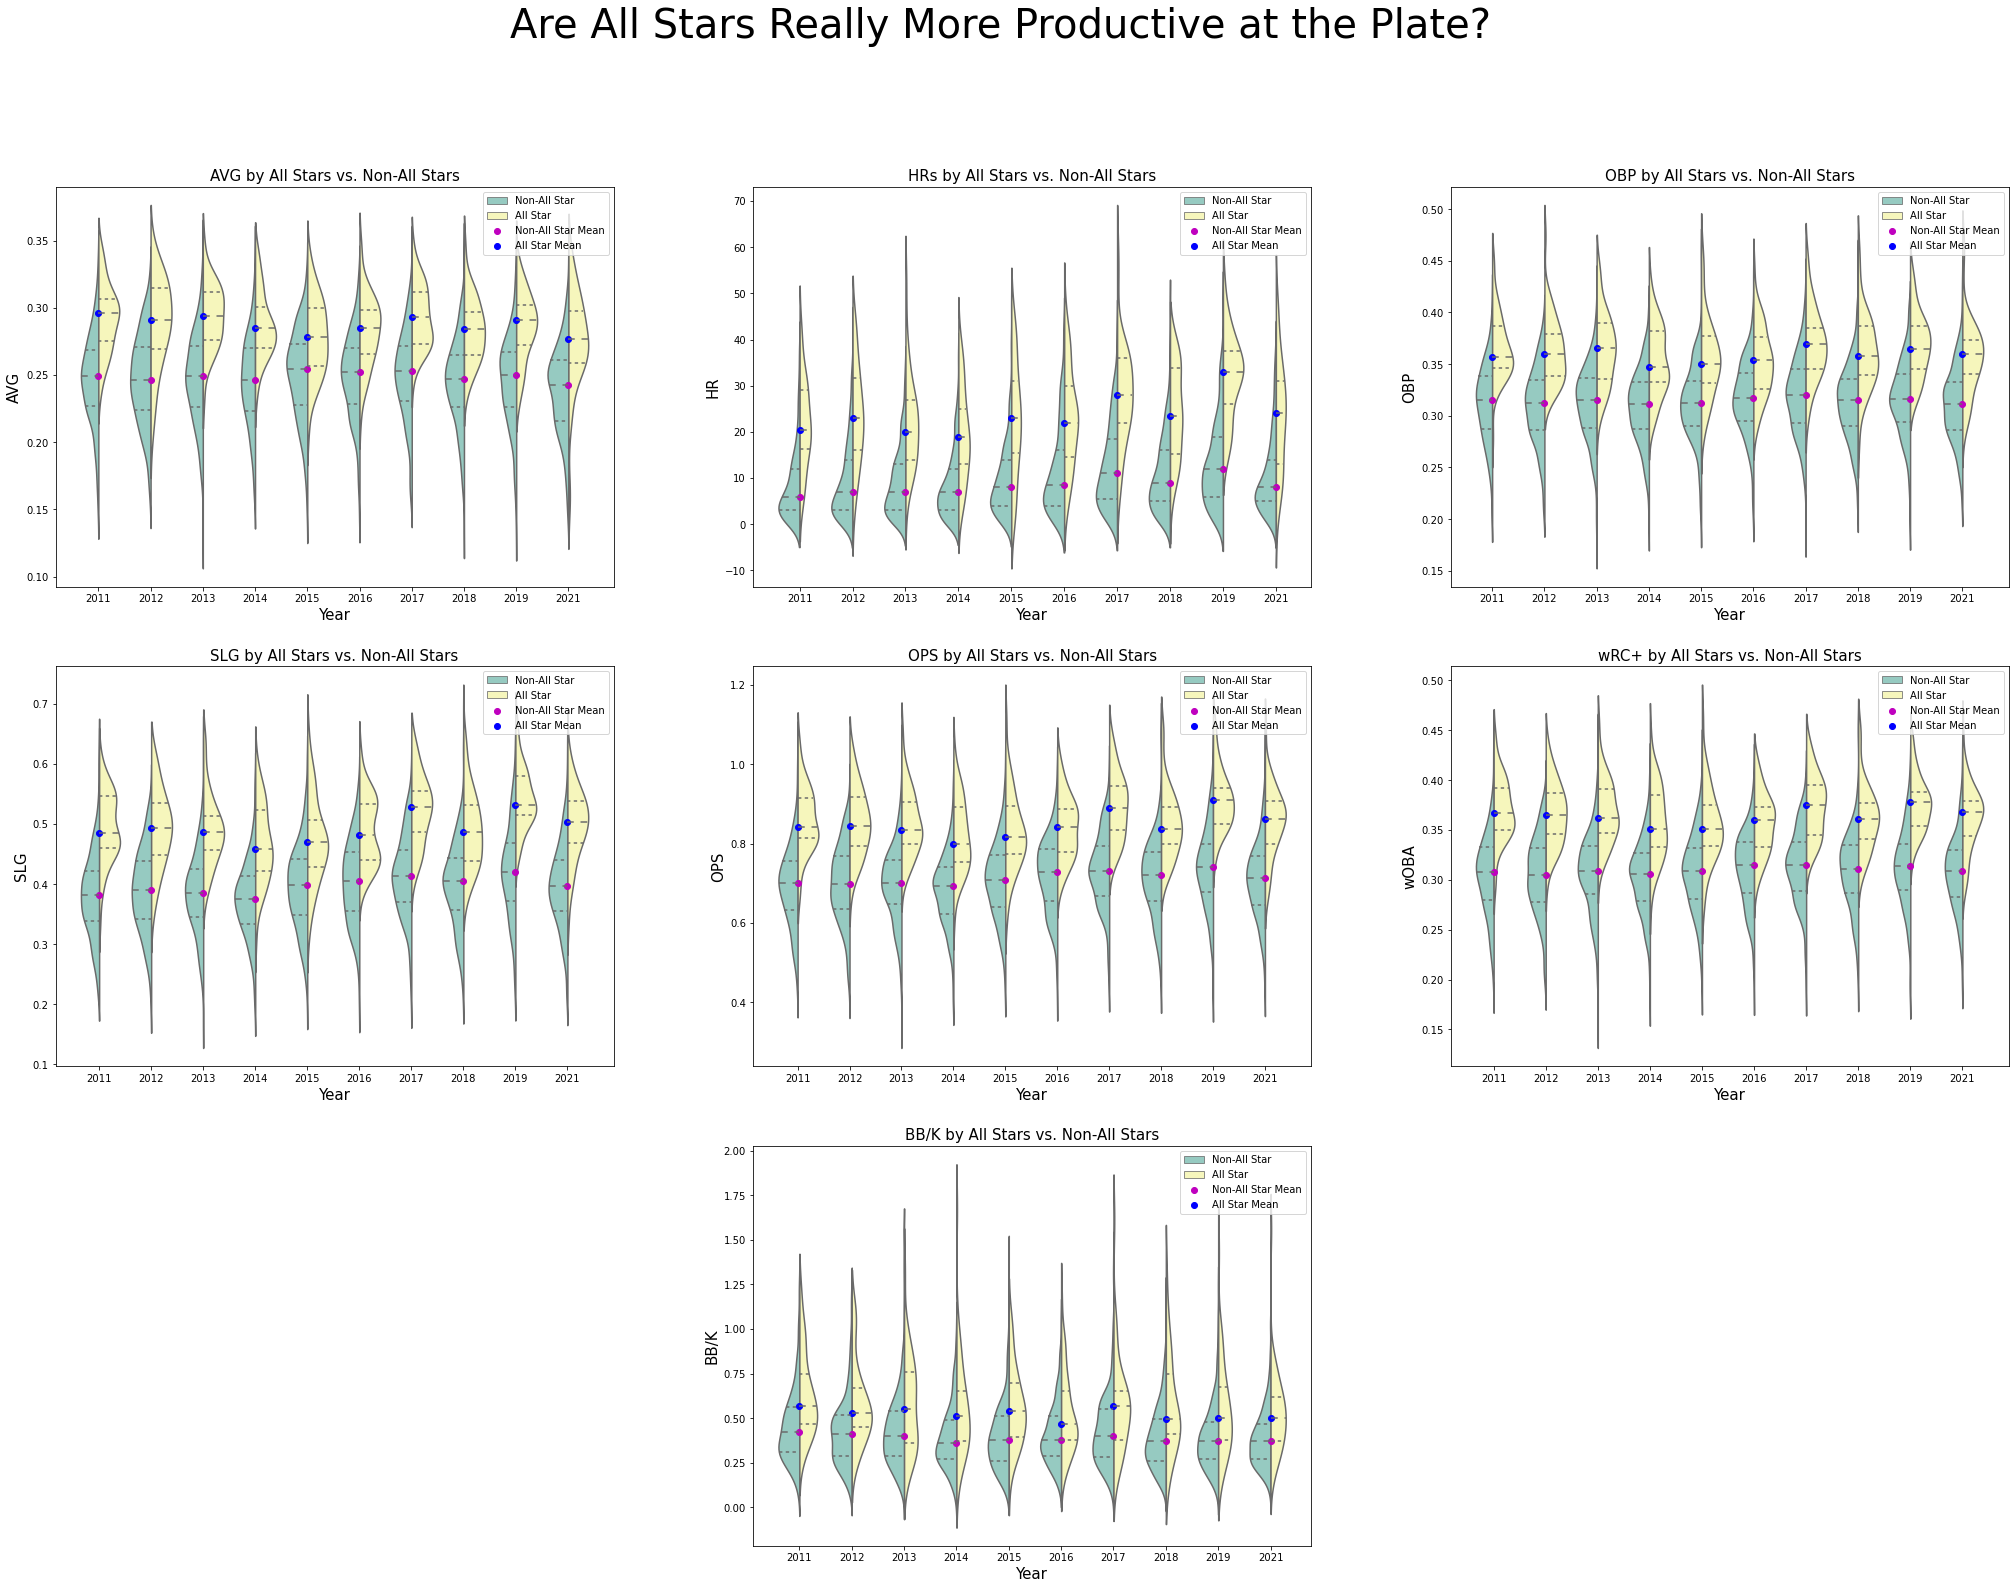

In [5]:
# The All Star game was not held in 2020 due to COVID so do not include this year in data
players = player_table[player_table.Year != 2020]

# Drop the playerID column because we don't need it
players = players.drop(['playerID'], axis=1)

# Only include players with at least 200 at-bats so that small sample sizes do not skew the data.
# FOr example, a plaer could go 5/7 with 5 homeruns after being called up for the final series in September,
# but even though he did fantastic, 7 at bats isn't going to get him a nomination, especially since the ASG is in July
players = players[players.AB > 100]

players['All_Star'] = players['All_Star'].replace({0 : 'Non-All Star', 1 : 'All Star'})

fig, ax = plt.subplots(3, 3)
fig.subplots_adjust(wspace=.25)
fig.set_figheight(25)
fig.set_figwidth(35)
fig.delaxes(ax[2,0])
fig.delaxes(ax[2,2])
fig.suptitle("Are All Stars Really More Productive at the Plate?", fontsize=40)

######################################################################
#         Plotting AVG for All Stars and Non-All Stars               #
######################################################################

plt.sca(ax[0,0])
plt.gca().set_title('AVG by All Stars vs. Non-All Stars', fontsize=15)
plt.gca().set_xlabel('Year', fontsize=15)
plt.gca().set_ylabel('Batting Average (AVG)', fontsize=15)

# Make violin plot for year and avg, splitting all stars and non-all stars by color
seaborn.violinplot(x="Year", y="AVG", data=players, split=True, hue='All_Star', palette='Set3', inner="quartile")

# Plot mean for all stars
means = players.groupby(['Year', 'All_Star'])['AVG'].median()

# Add points to the plot where x is the year and y is the mean of the metric
# Violin plot is labeled by year, but the axis ticks are really 0-9, so I need a dict to naviogate it
year_conversion = {2011:0, 2012:1, 2013:2, 2014:3, 2015:4, 2016:5, 2017:6, 2018:7, 2019:8, 2021:9}
count = 0
for year in range(2011, 2022):
    if year != 2020:
        if count == 0:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm', label='Non-All Star Mean')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue', label='All Star Mean')
            count = 1
        else:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue')

ax[0,0].legend()
        
######################################################################
#         Plotting HR for All Stars and Non-All Stars               #
######################################################################

plt.sca(ax[0,1])
plt.gca().set_title('HRs by All Stars vs. Non-All Stars', fontsize=15)
plt.gca().set_xlabel('Year', fontsize=15)
plt.gca().set_ylabel('Home Runs (HR)', fontsize=15)

# Make violin plot for year and hr, splitting all stars and non-all stars by color
seaborn.violinplot(x="Year", y="HR", data=players, split=True, hue='All_Star', palette='Set3', inner="quartile")

# Plot mean for all stars
means = players.groupby(['Year', 'All_Star'])['HR'].median()

# Add points to the plot where x is the year and y is the mean of the metric
# Violin plot is labeled by year, but the axis ticks are really 0-9, so I need a dict to naviogate it
year_conversion = {2011:0, 2012:1, 2013:2, 2014:3, 2015:4, 2016:5, 2017:6, 2018:7, 2019:8, 2021:9}
count = 0
for year in range(2011, 2022):
    if year != 2020:
        if count == 0:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm', label='Non-All Star Mean')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue', label='All Star Mean')
            count = 1
        else:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue')

ax[0,1].legend()

######################################################################
#         Plotting OBP for All Stars and Non-All Stars               #
######################################################################

plt.sca(ax[0,2])
plt.gca().set_title('OBP by All Stars vs. Non-All Stars', fontsize=15)
plt.gca().set_xlabel('Year', fontsize=15)
plt.gca().set_ylabel('On-Base Percentage (OBP)', fontsize=15)

# Make violin plot for year and obp, splitting all stars and non-all stars by color
seaborn.violinplot(x="Year", y="OBP", data=players, split=True, hue='All_Star', palette='Set3', inner="quartile")

# Plot mean for all stars
means = players.groupby(['Year', 'All_Star'])['OBP'].median()

# Add points to the plot where x is the year and y is the mean of the metric
# Violin plot is labeled by year, but the axis ticks are really 0-9, so I need a dict to naviogate it
year_conversion = {2011:0, 2012:1, 2013:2, 2014:3, 2015:4, 2016:5, 2017:6, 2018:7, 2019:8, 2021:9}
count = 0
for year in range(2011, 2022):
    if year != 2020:
        if count == 0:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm', label='Non-All Star Mean')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue', label='All Star Mean')
            count = 1
        else:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue')

ax[0,2].legend()

######################################################################
#          Plotting SLG for All Stars and Non-All Stars              #
######################################################################

plt.sca(ax[1,0])
plt.gca().set_title('SLG by All Stars vs. Non-All Stars', fontsize=15)
plt.gca().set_xlabel('Year', fontsize=15)
plt.gca().set_ylabel('Slugging Percentage (SLG)', fontsize=15)

# Make violin plot for year and slg, splitting all stars and non-all stars by color
seaborn.violinplot(x="Year", y="SLG", data=players, split=True, hue='All_Star', palette='Set3', inner="quartile")

# Plot mean for all stars
means = players.groupby(['Year', 'All_Star'])['SLG'].median()

# Add points to the plot where x is the year and y is the mean of the metric
# Violin plot is labeled by year, but the axis ticks are really 0-9, so I need a dict to naviogate it
year_conversion = {2011:0, 2012:1, 2013:2, 2014:3, 2015:4, 2016:5, 2017:6, 2018:7, 2019:8, 2021:9}
count = 0
for year in range(2011, 2022):
    if year != 2020:
        if count == 0:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm', label='Non-All Star Mean')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue', label='All Star Mean')
            count = 1
        else:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue')

ax[1,0].legend()

######################################################################
#          Plotting OPS for All Stars and Non-All Stars              #
######################################################################

plt.sca(ax[1,1])
plt.gca().set_title('OPS by All Stars vs. Non-All Stars', fontsize=15)
plt.gca().set_xlabel('Year', fontsize=15)
plt.gca().set_ylabel('On-Base Plus Slugging (OPS)', fontsize=15)

# Make violin plot for year and ops, splitting all stars and non-all stars by color
seaborn.violinplot(x="Year", y="OPS", data=players, split=True, hue='All_Star', palette='Set3', inner="quartile")

# Plot mean for all stars
means = players.groupby(['Year', 'All_Star'])['OPS'].median()

# Add points to the plot where x is the year and y is the mean of the metric
# Violin plot is labeled by year, but the axis ticks are really 0-9, so I need a dict to naviogate it
year_conversion = {2011:0, 2012:1, 2013:2, 2014:3, 2015:4, 2016:5, 2017:6, 2018:7, 2019:8, 2021:9}
count = 0
for year in range(2011, 2022):
    if year != 2020:
        if count == 0:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm', label='Non-All Star Mean')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue', label='All Star Mean')
            count = 1
        else:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue')

ax[1,1].legend()

######################################################################
#         Plotting wOBA for All Stars and Non-All Stars              #
######################################################################

plt.sca(ax[1,2])
plt.gca().set_title('wRC+ by All Stars vs. Non-All Stars', fontsize=15)
plt.gca().set_xlabel('Year', fontsize=15)
plt.gca().set_ylabel('Weighted On-Base Average (wOBA)', fontsize=15)

# Make violin plot for year and woba, splitting all stars and non-all stars by color
seaborn.violinplot(x="Year", y="wOBA", data=players, split=True, hue='All_Star', palette='Set3', inner="quartile")

# Plot mean for all stars
means = players.groupby(['Year', 'All_Star'])['wOBA'].median()

# Add points to the plot where x is the year and y is the mean of the metric
# Violin plot is labeled by year, but the axis ticks are really 0-9, so I need a dict to naviogate it
year_conversion = {2011:0, 2012:1, 2013:2, 2014:3, 2015:4, 2016:5, 2017:6, 2018:7, 2019:8, 2021:9}
count = 0
for year in range(2011, 2022):
    if year != 2020:
        if count == 0:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm', label='Non-All Star Mean')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue', label='All Star Mean')
            count = 1
        else:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue')

ax[1,2].legend()

######################################################################
#         Plotting BB/K for All Stars and Non-All Stars              #
######################################################################

plt.sca(ax[2,1])
plt.gca().set_title('BB/K by All Stars vs. Non-All Stars', fontsize=15)
plt.gca().set_xlabel('Year', fontsize=15)
plt.gca().set_ylabel('Walk to Strikeout Rate (BB/K)', fontsize=15)

# Make violin plot for year and bb/k, splitting all stars and non-all stars by color
seaborn.violinplot(x="Year", y="BB/K", data=players, split=True, hue='All_Star', palette='Set3', inner="quartile")

# Plot mean for all stars
means = players.groupby(['Year', 'All_Star'])['BB/K'].median()

# Add points to the plot where x is the year and y is the mean of the metric
# Violin plot is labeled by year, but the axis ticks are really 0-9, so I need a dict to naviogate it
year_conversion = {2011:0, 2012:1, 2013:2, 2014:3, 2015:4, 2016:5, 2017:6, 2018:7, 2019:8, 2021:9}
count = 0
for year in range(2011, 2022):
    if year != 2020:
        if count == 0:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm', label='Non-All Star Mean')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue', label='All Star Mean')
            count = 1
        else:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue')
            
ax[2,1].legend()

plt.show()

As the plots show, All Stars are most certainly more productive at the plate than non-All Stars. In the plot, I made a split violin plot with the light green side being non-All Stars and the light yellow side being All Stars. I then grouped the dataframe by All Stars and non-All Stars and calculated the average of the metric we were plotting for each year in the dataset. The quartiles are printed inside each violin distribution, and the mean is highlighted by a point on the plot. The blue points represent the median for All Stars and the magenta points represent the median for the non-All Stars. As you can see in every single plot, the median of the offensive metrics is much higher for All Stars than they are for non-All Stars. As we showed in the previous sections, these stats correlate to offensive production, thus, we can say that since the All Stars have higher average marks for these metrics, they are in fact, more prodcutive than non-All Stars. This trend seems to indicate that All Stars are indeed nominated by their production, rather than popularity.

### VI: Do All Stars Get Paid More Than Non-All Stars?

As a fun and interesting aside, I also decided to investigate whether or not All Stars get paid more than their Non-All Star counterparts. Intuitively, I predict they do, because players tend to become All Stars in their prime years, which is when they should be off the league minimum salary. Also, since we determined in the last section that All Stars are more productive, teams will be more likely to pay them more because production often comes at a premium unless you have a phenom like Bryce Harper, who has been making the All Star game since his rookie year when he was 19-years old. If a team is lucky enough to have a rookie become an All Star, then the player will have a low salary because for the first six years of a MLB career, players do not have free reign to sign anywhere (teams own their rights during this time), so the team can offer them lower salaries and the player will have to just play basically at whatever is offered. However, this only happens for generational players, so I expect the plot to show an overall trend that All Stars have higher salaries than Non-All Stars.

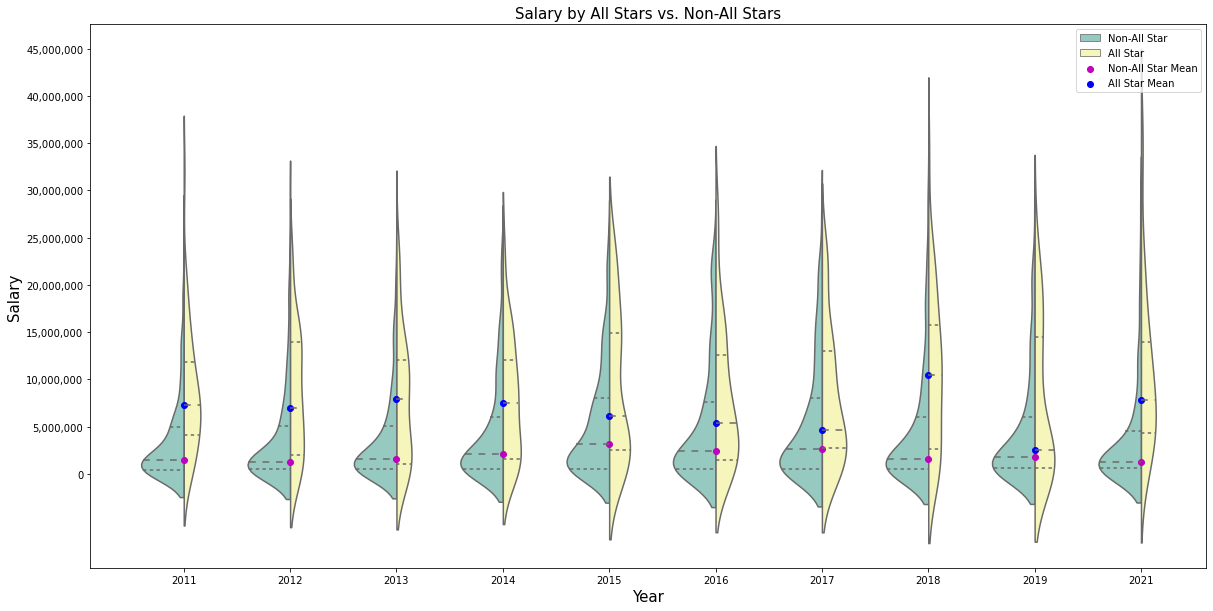

In [ ]:
# The All Star game was not held in 2020 due to COVID so do not include this year in data
players = player_table[player_table.Year != 2020]

# Drop the playerID column because we don't need it
players = players.drop(['playerID'], axis=1)

# Only include players with at least 200 at-bats so that small sample sizes do not skew the data.
# FOr example, a plaer could go 5/7 with 5 homeruns after being called up for the final series in September,
# but even though he did fantastic, 7 at bats isn't going to get him a nomination, especially since the ASG is in July
players = players[players.AB > 100]

players['All_Star'] = players['All_Star'].replace({0 : 'Non-All Star', 1 : 'All Star'})

# Cast the values of Salary column as an int
players['Salary'] = players['Salary'].astype(int)

fig, ax = plt.subplots()
fig.subplots_adjust(wspace=.25)
fig.set_figheight(10)
fig.set_figwidth(20)

plt.sca(ax)
plt.gca().set_title('Salary by All Stars vs. Non-All Stars', fontsize=15)
plt.gca().set_xlabel('Year', fontsize=15)
plt.gca().set_ylabel('Salary ($)', fontsize=15)

seaborn.violinplot(x="Year", y="Salary", data=players, split=True, hue='All_Star', palette='Set3', inner="quartile")

# Plot mean for all stars
means = players.groupby(['Year', 'All_Star'])['Salary'].median()

# Add points to the plot where x is the year and y is the mean of the metric
# Violin plot is labeled by year, but the axis ticks are really 0-9, so I need a dict to naviogate it
year_conversion = {2011:0, 2012:1, 2013:2, 2014:3, 2015:4, 2016:5, 2017:6, 2018:7, 2019:8, 2021:9}
count = 0
for year in range(2011, 2022):
    if year != 2020:
        if count == 0:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm', label='Non-All Star Mean')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue', label='All Star Mean')
            count = 1
        else:
            plt.scatter(x=year_conversion[year], y=means[year]['Non-All Star'], color = 'm')
            plt.scatter(x=year_conversion[year], y=means[year]['All Star'], color = 'blue')

# Change yticks from scientific notation to more readable
plt.yticks(np.arange(0, 50000000, 5000000))
label_format = '{:,.0f}'
ticks_loc = plt.gca().get_yticks().tolist()
plt.gca().yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
plt.gca().set_yticklabels([label_format.format(y) for y in ticks_loc])

# Add legend to plot
ax.legend()
 
plt.show()

As I expected, the plot shows that All Stars are paid, on average, more than Non-All Stars. Again, this makes sense because more productive players usually make more money, and we showed that All Stars are more productive than Non-All Stars in section V.

### Conclusion

As I have shown throughout this project, there are very distinct metrics that we keep track of in baseball that help determine a player's worth, value, and production to a team. The most indicative metric for offensive production is on-base plus slugging percentage (OPS), as this is the metric that correlated to scoring runs the most. The other statistics, most specifically OBP, SLG, and wOBA, were also highly correlated. In the process, we also showed that batting average and homeruns, while they do moderately correlate to scoring runs, are not the best representation of offensive production. With our final analysis of offensive production, we found that a player who is able to work counts, and make good swing decisions (swinging at hittable pitches, not swinging at pitcher's pitches) is going to be more productive at the plate. 

Then, tying it all together, we studied how offensive production correlates to All Star game nominations. Through our analysis, we found that All Star game nominations are, in fact, related to offensive production, instead of just player or team popularity. In additon to offensive production, we also looked at how All Star game nominations are related to player salaries and found that All Stars, on average, are paid more than Non-All Stars. This likely is due to a couple of reasons -- productive players make more money than unproductive players and All Stars tend to be players in their prime, and players in their prime are on contracts that pay them more than when they were rookies.